In [1]:
# -*- coding: utf-8 -*-

In [144]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from html_table_parser import parser_functions as parse
from time import sleep
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import random
import matplotlib.pyplot as plt
import math
% matplotlib inline

In [3]:
import lxml
import requests
import html5lib
pd.options.display.max_rows = 50

In [4]:
from bokeh.models import HoverTool, CategoricalColorMapper, OpenURL, TapTool
from bokeh.plotting import ColumnDataSource, figure, output_file, show, save, output_notebook

In [5]:
table_pages = ['https://en.wikipedia.org/wiki/List_of_battles_before_301',
               'https://en.wikipedia.org/wiki/List_of_battles_301%E2%80%931300',
               'https://en.wikipedia.org/wiki/List_of_battles_1301%E2%80%931600',
               'https://en.wikipedia.org/wiki/List_of_battles_since_2001']

In [6]:
list_pages = ['https://en.wikipedia.org/wiki/List_of_battles_1601%E2%80%931800',
               'https://en.wikipedia.org/wiki/List_of_battles_1801%E2%80%931900',
               'https://en.wikipedia.org/wiki/List_of_battles_1901%E2%80%932000',]

In [ ]:
def list_battles(url):
    req = requests.get(url)
    print req.status_code
    era = req.content
    era_soup = BeautifulSoup(era)
    bullets = era_soup.find_all('li')
    
    for bullet in bullets:
        print bullet
        if 'title' in str(bullet):
#             if 'expedition' or 'recapture' or 'capture' or 'war' or 'action' or 'battle' or 'siege' or 'operation' or 'fall' in str(bullet).lower():
#                 if 'List+of+battles' not in str(bullet):
                    if 'footer' not in str(bullet):
                        link = bullet.a['href']
                        link_list.append(link)

                        title = bullet.a['title']
                        title_list.append(title)
                    else:
                        print 'NEXT ENTRY: ' + str(bullet)
#                 else:
#                     print 'NEXT ENTRY: ' + str(bullet)
#             else:
#                 print 'NEXT ENTRY: ' + str(bullet)
        else: 
            print 'NEXT ENTRY' + str(bullet)
                    

In [ ]:
title_list = []
link_list = []
for url in list_pages:
    list_battles(url)

In [ ]:
link_list

In [ ]:
df_late_battles = pd.concat([pd.Series(link_list), pd.Series(title_list)], axis = 1).drop_duplicates()

In [ ]:
df_late_battles = df_late_battles.rename(columns = {0:'url', 1:'Battle'})

In [ ]:
df_late_battles

In [ ]:
df_late_battles[~df_late_battles['Battle'].str.contains('Battle' or 'Operation')]

In [ ]:
df_late_battles.to_csv('battle_list_1600-', encoding = 'utf-8')

In [ ]:
df_late_battles = pd.read_csv('battle_list_1600-.csv', encoding = 'utf-8')

In [ ]:
df_late_battles.head()

In [ ]:
df_late_battles = df_late_battles.drop(['Column1', 'Column4'], axis = 1)
df_late_battles.columns = df_late_battles.iloc[0]
df_late_battles = df_late_battles.drop(0)

In [ ]:
battle_list = []
link_list = []

In [ ]:
def early_battles(link):
    req = requests.get(link)
    print req.status_code
    era = req.content
    era_soup = BeautifulSoup(era)
    tables = era_soup.find_all('table', {'class': 'wikitable'})

    for table in tables:
        cells = table.find_all('td')
        for cell in cells:
            if cell.a is not None:
                a = ['Fall', 'Battle', 'Siege', 'Capture', 'Operation', 'Action', 'Recapture']
                if any(x in str(cell.a['href']) for x in a):
                    battle_list.append(cell.a['title'])
                    link_list.append(cell.a['href'])

In [ ]:
for page in table_pages:
    print page
    early_battles(page)

In [ ]:
df_battles = pd.DataFrame({'battle': battle_list,
                          'link':link_list})

In [ ]:
df_battles = df_battles.rename(columns = {'link':'url', 'battle':'Battle'})

In [ ]:
len(df_battles)

In [ ]:
len(df_late_battles)

In [ ]:
df_battles.head()

In [ ]:
df_url = pd.concat([df_late_battles, df_battles]).reset_index(drop = True)

In [ ]:
len(df_url)

In [ ]:
len(df_url.drop_duplicates())

In [ ]:
s_req = requests.get('https://en.wikipedia.org/Alexander_the_Great')

soup = BeautifulSoup(s_req.text)

ul = soup.find('ul', {'class':'redirectText'})

In [ ]:
if ul is not None:
    print 'works'

In [ ]:
df_battle_all = pd.DataFrame()
df_battle = pd.DataFrame()
def table_scrape(url, name):
#     sleep(1)
    print name
    link = 'https://en.wikipedia.org' + url
    b_req = requests.get(link)

    soup = BeautifulSoup(b_req.text)
    
    bell = soup.find('table', {'class':'infobox vevent'})
    
    if bell is not None:

        details = pd.DataFrame(parse.make2d(bell))
    else:
        return b_req
    

    if 'Belligerents' in str(bell):
    
        clean_rows = details.drop_duplicates(0).set_index(0,drop = True).loc[['Date', 'Location', 'Result'],:]

        clean_col = clean_rows.transpose().reset_index(drop = True)

        df_x_bells = pd.DataFrame()

        html_table = bell.find_all('tr')
        bell_list = []
        bell_y_list = []

        for index, cell in zip(range(0, len(html_table)), html_table):
            if 'Commanders and leaders' in str(cell):
                leaders = html_table[index + 1]
                cells = leaders.find_all('td')
                count = 0
                for cell in cells:
                    count += 1
                    anchors = cell.find_all('a')
                    for anchor in anchors:
                        if 'title' in str(anchor):
                            if 'class="image"' in str(anchor):
                                cl = 'image'
                            elif 'class="thumbborder"' in str(anchor):
                                cl = 'thumb'
                            elif 'cite_note' in str(anchor):
                                cl = 'cite'
                            elif 'disambiguation needed' in str(anchor):
                                cl = 'disam'
                            elif 'cnote_g' in str(anchor):
                                cl = 'cnote'
                            else:
                                title = anchor['title']
                                if any(title == x for x in ['Napoleon I','Alexander III of Macedon']):
                                    print 'napoleon or alex redirect'

                                ref = anchor['href']
                                link = 'https://en.wikipedia.org' + ref

                                if len(ref) <= 10:
                                    t_req = requests.get(link)
                                elif any(ref[8] + ref[9] + ref[10] == x for x in ['pt.', 'tr.', 'ko.', 'ja.', 'th.','da.', 'es.', 'de.', 'it.', 'fr.', 'zh.']):
                                    print 'Not English!'
                                    link = ref
                                    t_req = requests.get(link)
                                elif soup.find('ul', {'class':'redirectText'}) is not None:
                                    print 'REDIRECT'
                                    print title
                                    ul = soup.find('ul', {'class':'redirectText'})
                                    a = ul.a
                                    redirect = a['href']
                                    link = 'https://en.wikipedia.org' + redirect
                                    t_req = requests.get(link)
                                else:
                                    t_req = requests.get(link)

                                t_soup = BeautifulSoup(t_req.text)

                                c_name = t_soup.find('title')
                                c_name = str(c_name)

                                if c_name:
                                    c_name = c_name.replace(' - Wikipedia', '').replace('<title>', '').replace('</title>', '')
                                else:
                                    if count == 1:
                                        bell_list.append(title)
                                    elif count == 2:
                                        bell_y_list.append(title)
                                if 'ex.php?title=' in ref:
                                    ref = ref.replace('ex.php?title=', '')
                                    ref = ref.replace('&action=edit&redlink=1', '')

                                omit_list = ['Capital punishment', 
                                             'Military advisor', 
                                             'Wounded in action', 
                                             'Prisoner of war', 
                                             'Killed in action', 
                                             'Surrender (military)', 
                                             'Surrendered',
                                             'Common military ranks in English']

                                if all(c_name != x for x in omit_list):


                                    if count == 1:

                                        bell_list.append(c_name)
                                    elif count == 2:
                                        bell_y_list.append(c_name)



        for bell in bell_list:
            clean_col['belligerent'] = bell
            df_x_bells = pd.concat([df_x_bells, clean_col])
            df_x_bells = df_x_bells.reset_index(drop = True)


        df_y_bells = pd.DataFrame()
        for bell in bell_y_list:
            clean_col['belligerent'] = bell
            df_y_bells = pd.concat([df_y_bells, clean_col])
            df_y_bells = df_y_bells.reset_index(drop = True)

        df_y_bells = df_y_bells.rename(columns = {0:'Location'})

        if 'Strength' in str(details[0]):
            strength_finder = details[details[0] == 'Strength']


            strength_row = strength_finder.index + 1

            strength = details.loc[strength_row]

            strength_x = strength.iloc[0,0]

            strength_y = strength.iloc[0,1]
        else:
            strength_x = 'unknown'
            strength_y = 'unknown'

        df_x_bells['own'] = strength_x

        df_x_bells['opp'] = strength_y

        df_y_bells['own'] = strength_y

        df_y_bells['opp'] = strength_x

        if 'Casualties and losses' not in str(details[0]):
            df_x_bells['taken'] = np.NaN
            df_x_bells['inflicted'] = np.NaN
            df_y_bells['taken'] = np.NaN
            df_y_bells['inflicted'] = np.NaN

        else:

            casualties_finder = details[details[0] == 'Casualties and losses']

            casualties_row = casualties_finder.index + 1

            casualties = details.loc[casualties_row]

            casualties_x = casualties.iloc[0,0]

            casualties_y = casualties.iloc[0,1]

            df_x_bells['taken'] = casualties_x

            df_x_bells['inflicted'] = casualties_y

            df_y_bells['taken'] = casualties_y

            df_y_bells['inflicted'] = casualties_x



        df_x_bells['Battle'] = name

        df_y_bells['Battle'] = name

        df_x_bells['pos'] = 'L'

        df_y_bells['pos'] = 'R'

        df_battle = pd.concat([df_x_bells, df_y_bells]).reset_index(drop = True)

        df_battle_all = pd.concat([df_battle_all, df_battle]).reset_index(drop = True).drop_duplicates()

        global df_battle_all
    else:
        print 'Filtered: ' + name

In [ ]:
count = 0
for num, rows in {1:df_url[:200],
             2:df_url[200:400], 
             3:df_url[400:600], 
             4:df_url[600:800],
             5:df_url[800:1000],
             6:df_url[1000:1200],
             7:df_url[1200:1400],
             8:df_url[1400:1600],
             9:df_url[1600:1800],
             10:df_url[1800:2000],
             11:df_url[2000:2200],
             12:df_url[2200:2400],
             13:df_url[2400:2600],
             14:df_url[2600:2800],
             15:df_url[2800:3000],
             16:df_url[3000:3200],
             17:df_url[3200:3400],
             18:df_url[3400:]}.iteritems():
    df_battle = pd.DataFrame()
    df_batch = rows
    for index, row in df_batch.iterrows():
        count += 1
        global count
        print str(count) + '/' + str(len(df_url))
        table_scrape(row['url'], row['Battle'])
    df_battle_all.to_csv('rows_{}.csv'.format(num), encoding = 'utf-8')
    print 'NEW FRAME' + str(num)

In [ ]:
row_list = ['rows_1.csv',
 'rows_2.csv',
 'rows_3.csv',
 'rows_4.csv',
 'rows_5.csv',
 'rows_6.csv',
 'rows_7.csv',
 'rows_8.csv',
 'rows_9.csv',
 'rows_10.csv',
 'rows_11.csv',
 'rows_12.csv',
 'rows_13.csv',
 'rows_14.csv',
 'rows_15.csv',
 'rows_16.csv',
 'rows_17.csv',
 'rows_18.csv']

In [ ]:
df_comm = pd.DataFrame()
for sheet in row_list:
    df_rows = pd.read_csv(sheet)
    df_comm = pd.concat([df_comm, df_rows]).reset_index(drop = True)

In [ ]:
df_comm = df_comm.drop('Unnamed: 0', axis = 1)

In [ ]:
len(df_comm)

In [ ]:
len(df_comm)

In [ ]:
df_comm.to_csv('battles_dirty.csv', encoding = 'utf-8')

In [ ]:
df_comm = pd.read_csv('battles_dirty.csv').drop('Unnamed: 0', axis = 1)

In [ ]:
df_comm = df_comm.drop_duplicates()

In [ ]:
df_comm.head()

In [ ]:
len(df_comm)

In [ ]:
df_comm[df_comm.belligerent.str.contains('Nasser')]

In [ ]:
len(df_comm.drop_duplicates())

In [ ]:
df_comm = df_comm.drop_duplicates().reset_index(drop = True)

In [ ]:
df_comm.to_csv('battles_deduped.csv')

In [ ]:
len(df_comm[df_comm.belligerent.str.contains('Napoleon')])

In [ ]:
df_comm[df_comm.belligerent.str.contains('Scipio')]

In [ ]:
df_results = pd.read_csv('result_column.csv')

In [ ]:
df_results[df_results.Battle == 'Battle_of_Camarón']

In [ ]:
df_comm.head()

In [ ]:
df_results.head()

In [ ]:
df_more_results = pd.merge(df_comm, df_results, how = 'outer', on = ['Battle', 'belligerent', 'pos', 'Result'])

In [ ]:
df_more_results = df_more_results[df_more_results.VorD.isnull()]

In [ ]:
df_more_results = df_more_results.drop_duplicates(subset = ['Battle', 'Date', 'VorD'])

In [ ]:
df_more_results.head()

In [ ]:
df_more_results.to_csv('adding_results_10.21.csv', encoding = 'utf-8')

In [ ]:
df_comm[df_comm.Battle == 'Battle_of_Camarón']

In [ ]:
df_comm[df_comm.belligerent == 'Ambroise de Loré']

In [ ]:
df_vl = pd.merge(df_comm, df_results, how = 'outer', on = ['Battle', 'belligerent', 'Result', 'pos'])

In [ ]:
df_vl

In [ ]:
df_vl = df_vl.sort('VorD')

In [ ]:
df_vl[df_vl.belligerent == 'Ambroise de Loré']

In [ ]:
df_vl[df_vl.belligerent == 'Saracens']

In [ ]:
df_vl.to_csv('additional_results.csv')

In [ ]:
df_10_21_fill = df_vl[df_vl.VorD.isnull()]

In [ ]:
df_ar = pd.read_csv('additional_results.csv', encoding = 'utf-8')

In [ ]:
df_strength = df_ar.drop(['Unnamed: 0', 'Location', 'Result', 'inflicted', 'taken', 'opp'], axis = 1)

In [ ]:
df_strength = df_strength.sort('Battle').reset_index(drop = True)

In [ ]:
df_strength_dd = df_strength.drop_duplicates(['own', 'pos'], keep = 'first')

In [ ]:
df_strength_dd.own = df_strength_dd.own.str.replace('\r',' ').str.replace('\n', ' ').replace('\n', ' ')

In [ ]:
df_strength_dd = df_strength_dd.sort('Battle').reset_index(drop = True)

In [ ]:
df_strength_dd

In [ ]:
df_strength_dd.to_csv('strength_entry.csv', encoding = 'utf-8')

In [ ]:
df_strength_new = df_strength.drop_duplicates(['own', 'pos', 'Battle'], keep = 'first')

In [ ]:
df_strength_fill = pd.read_excel('strength_entry.xlsx', encoding = 'utf-8')

In [ ]:
df_battles = pd.read_csv('battles_deduped.csv', encoding = 'utf-8').drop('Unnamed: 0', axis = 1)

In [ ]:
df_battles = df_battles.drop(['taken', 'inflicted'], axis = 1)

In [ ]:
df_strength_fill.Battle = df_strength_fill.Battle.str.replace(u"â€“",u'–')

In [ ]:
df_some_strength = pd.merge(df_battles, df_strength_fill, how = 'outer', on = ['Battle', 'pos']).drop(['own_y', 'belligerent_y', 'Date_y'], axis = 1).rename(columns = {'Date_x':'Date','own_x':'own', 'belligerent_x':'belligerent'})

In [ ]:
df_some_strength[df_some_strength.Battle.str.contains('Battle_of_Jena')]

In [ ]:
df_test = df_some_strength.iloc[:,9:]

In [ ]:
df_str_two = df_some_strength[df_some_strength['Infantry'].isnull() & df_some_strength['Cavalry'].isnull() & df_some_strength['Artillery'].isnull() & df_some_strength['Ships'].isnull() & df_some_strength['Airforce'].isnull() & df_some_strength['Special'].isnull()]

In [ ]:
df_str_two.head()

In [ ]:
df_str_two = df_str_two.drop_duplicates(['Battle', 'Date', 'Location', 'Result', 'pos']).drop('VorD', axis = 1)

In [ ]:
len(df_str_two)

In [ ]:
df_merger = df_strength.drop(['Date', 'belligerent', 'own'], axis = 1)

In [ ]:
df_merger = df_merger.drop_duplicates()

In [ ]:
df_str_two.head()

In [ ]:
df_str_two = pd.merge(df_str_two, df_merger, on = ['Battle', 'pos'], how = 'outer').dropna(subset = ['Date', 'Location', 'Result'])

In [ ]:
df_str_two = df_str_two.dropna(subset = ['VorD'])

In [ ]:
df_str_two.to_csv('strength_entry_two.csv')

In [ ]:
df_str_two

In [ ]:
df_partial = pd.read_excel('PARTIAL_strength_entry_two.xlsx', encoding = 'utf-8')

In [ ]:
df_str_two.head()

In [ ]:
df_str_two = df_str_two.drop(['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special'], axis = 1)

In [ ]:
df_partial = df_partial.drop(['Date', 'Location', 'Result', 'belligerent','own', 'Column1'],axis = 1)

In [ ]:
df_partial.columns

In [ ]:
df_str_two.head()

In [ ]:
df_finish = pd.merge(df_str_two, df_partial, on = ['Battle', 'pos', 'VorD'], how = 'outer')

In [ ]:
drop_list = list(df_finish[df_finish['Date'].isnull()].index)

In [ ]:
df_finish = df_finish.drop(drop_list)

In [ ]:
df_finish.to_csv('last_strength_entry.csv', encoding = 'utf-8')

In [ ]:
df_some_strength

In [ ]:
df_some_strength[df_some_strength.Battle.str.contains('Siege of La Rochelle')]

In [7]:
df_more_strength = pd.read_excel('last_strength_entry.xlsx')

In [ ]:
df_more_strength.head()

In [ ]:
df_some_strength.head()

In [ ]:
df_more_strength = pd.merge(df_more_strength, df_str_two, on = ['Battle', 'pos'], how = 'outer').drop(['own_y', 'Infantry_y', 'Cavalry_y', 'Artillery_y', 'Ships_y', 'Airforce_y', 'Special_y', 'Date_y', 'Location_y', 'Result_y', 'belligerent_y'], axis = 1).dropna(subset = ['Date_x'])

In [ ]:
df_more_strength.columns = df_more_strength.columns.str.replace('_x', '')

In [ ]:
df_more_strength.head()

In [ ]:
df_some_strength.head()

In [ ]:
df_more_strength

In [ ]:
df_fill_two = pd.merge(df_battles, df_more_strength, on = ['Battle', 'pos'], how = 'outer').drop(['Date_y', 
                                                                                    'Location_y', 
                                                                                    'belligerent_y', 
                                                                                    'Result_y', 'own_y', 
                                                                                    'opp_y'], axis = 1)

In [ ]:
df_fill_two.columns = df_fill_two.columns.str.replace('_x', '')

In [ ]:
df_some_strength = df_some_strength[df_some_strength['Infantry'].notnull() | df_some_strength['Cavalry'].notnull() | df_some_strength['Artillery'].notnull() | df_some_strength['Ships'].notnull() | df_some_strength['Airforce'].notnull() | df_some_strength['Special'].notnull()]

In [ ]:
len(df_some_strength)

In [ ]:
df_fill_two = df_fill_two[df_fill_two['Infantry'].notnull() | df_fill_two['Cavalry'].notnull() | df_fill_two['Artillery'].notnull() | df_fill_two['Ships'].notnull() | df_fill_two['Airforce'].notnull() | df_fill_two['Special'].notnull()]

In [ ]:
df_some_strength

In [ ]:
df_fill_two

In [ ]:
df_all_strength = pd.concat([df_fill_two, df_some_strength]).reset_index(drop = True)

In [ ]:
len(df_battles)

In [ ]:
df_char = df_all_strength[df_all_strength.Date.isnull()]

In [ ]:
df_char.to_excel('special_character_fix.xlsx')

In [ ]:
df_all_strength[df_all_strength.Battle.str.contains('Battle_of_Tenn')]

In [ ]:
df_all_strength.to_excel('all_strength_probably.xlsx')

In [ ]:
df_battles[df_battles.Battle.str.contains('dlingen')]

In [ ]:
df_char.Battle

In [8]:
df_strength_all = pd.read_excel('all_strength_probably.xlsx')

In [9]:
df_strength_all = df_strength_all.drop_duplicates()

In [10]:
df_left = df_strength_all[df_strength_all.pos == 'L']

In [11]:
df_left = df_left.drop(['Date', 'Location', 'Result', 'belligerent', 'opp', 'own'], axis = 1)

In [12]:
df_left = df_left.drop_duplicates(subset = ['Battle'])

In [13]:
df_left = df_left.dropna(subset = ['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special'], how = 'all')

In [14]:
df_right = df_strength_all[df_strength_all.pos == 'R']

In [15]:
df_right = df_right.drop_duplicates(subset = ['Battle'])

In [16]:
df_right = df_right.drop(['Date', 'Location', 'Result', 'belligerent', 'opp', 'own', 'VorD'], axis = 1)

In [17]:
df_right = df_right.dropna(subset = ['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special'], how = 'all')

In [18]:
df_model = pd.merge(df_left, df_right, on = 'Battle', how = 'outer').dropna(subset = ['pos_x', 'pos_y']).reset_index(drop = True)

In [19]:
df_model

,Battle,pos_x,VorD,Infantry_x,Cavalry_x,Artillery_x,Ships_x,Airforce_x,Special_x,pos_y,Infantry_y,Cavalry_y,Artillery_y,Ships_y,Airforce_y,Special_y
0,1898_invasion_of_GuantÃ¡namo_Bay,L,V,923.0,NaN,NaN,6.0,NaN,NaN,R,5000.0,NaN,3.0,2.0,NaN,NaN
1,1948_Arab–Israeli_War,L,V,117500.0,NaN,NaN,NaN,NaN,NaN,R,58800.0,NaN,NaN,NaN,NaN,NaN
2,1982_Lebanon_War,L,I,113000.0,2397.0,NaN,NaN,634.0,NaN,R,37500.0,882.0,1125.0,NaN,450.0,NaN
3,1998_Battle_of_Kilinochchi,L,D,1.0,NaN,NaN,NaN,NaN,NaN,R,1.0,NaN,NaN,NaN,NaN,NaN
4,Abagana_Ambush,L,D,6000.0,NaN,NaN,NaN,NaN,NaN,R,700.0,NaN,NaN,NaN,NaN,NaN
5,Action_at_Bronkhorstspruit,L,D,268.0,NaN,NaN,NaN,NaN,NaN,R,250.0,NaN,NaN,NaN,NaN,NaN
6,Attack_on_Rabaul,L,V,NaN,NaN,NaN,16.0,631.0,NaN,R,NaN,NaN,NaN,21.0,200.0,NaN
7,Attack_on_Sydney_Harbour,L,I,NaN,NaN,NaN,19.0,NaN,NaN,R,NaN,NaN,NaN,8.0,2.0,NaN
8,"Battle of ""The Saw""",L,V,10000.0,2000.0,NaN,NaN,NaN,NaN,R,50000.0,NaN,NaN,NaN,NaN,NaN
9,Battle of Ã‡Ä±ldÄ±r,L,V,1.0,NaN,NaN,NaN,NaN,NaN,R,32000.0,NaN,NaN,NaN,NaN,NaN


In [20]:
df_model.VorD.value_counts()

V    1524
D     775
I     173
v       1
L       1
Name: VorD, dtype: int64

In [21]:
(1524 - 775) / 2

374.5

In [22]:
df_v = df_model[df_model.VorD == 'V']

In [23]:
v_list = list(df_v.index)

In [24]:
ran_list = random.sample(v_list, 374)

In [25]:
df_switch = df_model.iloc[ran_list]

In [26]:
df_switch['Infantry_hold'] = df_switch['Infantry_x']
df_switch['Cavalry_hold'] = df_switch['Cavalry_x']
df_switch['Artillery_hold'] = df_switch['Artillery_x']
df_switch['Ships_hold'] = df_switch['Ships_x']
df_switch['Airforce_hold'] = df_switch['Airforce_x']
df_switch['Special_hold'] = df_switch['Special_x']

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [27]:
df_switch['Infantry_x'] = df_switch['Infantry_y']
df_switch['Cavalry_x'] = df_switch['Cavalry_y']
df_switch['Artillery_x'] = df_switch['Artillery_y']
df_switch['Ships_x'] = df_switch['Ships_y']
df_switch['Airforce_x'] = df_switch['Airforce_y']
df_switch['Special_x'] = df_switch['Special_y']

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [28]:
df_switch['Infantry_y'] = df_switch['Infantry_hold']
df_switch['Cavalry_y'] = df_switch['Cavalry_hold']
df_switch['Artillery_y'] = df_switch['Artillery_hold']
df_switch['Ships_y'] = df_switch['Ships_hold']
df_switch['Airforce_y'] = df_switch['Airforce_hold']
df_switch['Special_y'] = df_switch['Special_hold']

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [29]:
df_switch = df_switch.drop(['Infantry_hold', 'Cavalry_hold', 'Artillery_hold', 'Ships_hold', 'Airforce_hold', 'Special_hold'], axis = 1)

In [30]:
df_switch.VorD = 'D'

In [31]:
df_switch.VorD.value_counts()

D    374
Name: VorD, dtype: int64

In [32]:
df_model = df_model.drop(ran_list)

In [33]:
df_model = pd.concat([df_model, df_switch])

In [34]:
df_model.VorD.value_counts()

V    1150
D    1149
I     173
v       1
L       1
Name: VorD, dtype: int64

In [35]:
df_model.loc[2378, 'Infantry_y'] = 25000

In [36]:
df_model.loc[2363, 'Infantry_x'] = 500

In [37]:
df_model = df_model[df_model.Infantry_x != 1.0]
df_model = df_model[df_model.Infantry_y != 1.0]

In [38]:
df_model = df_model.fillna(0)

In [39]:
df_model['infantry_diff'] = (df_model['Infantry_x'] - df_model['Infantry_y']) / (df_model['Infantry_x'] + df_model['Infantry_y'])
df_model['cavalry_diff'] = (df_model['Cavalry_x'] - df_model['Cavalry_y']) / (df_model['Cavalry_x'] + df_model['Cavalry_y'])
df_model['artillery_diff'] = (df_model['Artillery_x'] - df_model['Artillery_y']) / (df_model['Artillery_x'] + df_model['Artillery_y'])
df_model['ships_diff'] = (df_model['Ships_x'] - df_model['Ships_y']) / (df_model['Ships_x'] + df_model['Ships_y'])
df_model['airforce_diff'] = (df_model['Airforce_x'] - df_model['Airforce_y']) / (df_model['Airforce_x'] + df_model['Airforce_y'])
df_model['special_diff'] = (df_model['Special_x'] - df_model['Special_y']) / (df_model['Special_x'] + df_model['Special_y'])

In [40]:
df_diff = pd.concat([df_model['VorD'], df_model['Battle'], df_model['infantry_diff'],df_model['cavalry_diff'],df_model['artillery_diff'], df_model['ships_diff'],
                    df_model['airforce_diff'], df_model['special_diff']], axis = 1)

In [41]:
df_diff = df_diff[df_diff.VorD != 'I']

In [42]:
df_model[df_model.Battle == 'Siege of Noda']

,Battle,pos_x,VorD,Infantry_x,Cavalry_x,Artillery_x,Ships_x,Airforce_x,Special_x,pos_y,...,Artillery_y,Ships_y,Airforce_y,Special_y,infantry_diff,cavalry_diff,artillery_diff,ships_diff,airforce_diff,special_diff
2363,Siege of Noda,L,D,500.0,0.0,0.0,0.0,0.0,0.0,R,...,0.0,0.0,0.0,0.0,-0.967213,NaN,NaN,NaN,NaN,NaN


In [43]:
df_diff.sort_values('infantry_diff', ascending = False)

,VorD,Battle,infantry_diff,cavalry_diff,artillery_diff,ships_diff,airforce_diff,special_diff
2107,D,Bombardment_of_Algiers_(1816),1.000000,NaN,1.000000,-1.000000,NaN,NaN
622,V,Battle of Sudomer,1.000000,-1.000000,NaN,NaN,NaN,1.0
1217,D,Battle_of_Gangut,1.000000,NaN,NaN,-0.831776,NaN,NaN
1053,D,Battle_of_Copenhagen_(1801),1.000000,NaN,NaN,0.104478,NaN,NaN
1639,D,Battle_of_Palo_Duro_Canyon,1.000000,-1.000000,NaN,NaN,NaN,NaN
578,D,Battle of Salsu,1.000000,-1.000000,NaN,NaN,NaN,NaN
476,V,Battle of NÄ›meckÃ½ Brod,1.000000,-1.000000,NaN,NaN,NaN,NaN
327,D,Battle of Ikh Bayan,1.000000,-1.000000,NaN,NaN,NaN,NaN
677,D,Battle of the Ticinus,1.000000,-0.318681,NaN,NaN,NaN,NaN
506,D,Battle of Obertyn,1.000000,-0.582573,-0.612903,NaN,NaN,NaN


In [44]:
df_diff = df_diff.drop(174)

In [45]:
df_diff = df_diff.fillna(0)

In [46]:
df_x = pd.DataFrame(df_diff.iloc[:, 2:])

In [47]:
df_x = df_x.drop('artillery_diff', axis = 1)

In [48]:
df_y = pd.DataFrame(df_diff.iloc[:, 0])

In [49]:
df_y.VorD = df_y.VorD.replace('V', 1).replace('D', 0).replace('L', 0).replace('v', 1)

In [50]:
df_y.VorD = df_y.VorD.astype('float')

In [51]:
df_x = df_x.iloc[:, :-1]

In [52]:
lr = LogisticRegression()
lr.fit(df_x, df_y)

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [53]:
lr.score(df_x, df_y)

0.55161943319838058

In [54]:
pd.Series(df_x.columns)

0    infantry_diff
1     cavalry_diff
2       ships_diff
3    airforce_diff
dtype: object

In [55]:
lr.coef_[0]

array([ 0.40956764,  0.09800322,  0.57647249,  0.1123327 ])

In [56]:
pd.concat([pd.Series(lr.coef_[0]), pd.Series(df_x.columns)], axis = 1)

,0,1
0,0.409568,infantry_diff
1,0.098003,cavalry_diff
2,0.576472,ships_diff
3,0.112333,airforce_diff


In [57]:
df_test = pd.concat([df_y.reset_index(drop = True), pd.Series(lr.predict(df_x))], axis = 1)

In [58]:
df_test.head()

,VorD,0
0,1.0,0.0
1,1.0,1.0
2,0.0,1.0
3,0.0,0.0
4,1.0,0.0


In [59]:
len(df_test)

1976

In [60]:
count = 0
for i, row in df_test.iterrows():
    if row['VorD'] == row[0]:
        count = count + 1

In [61]:
scores = cross_val_score(lr, df_x, df_y.VorD, cv = 10)

In [62]:
scores.mean()

0.54151959353192136

In [63]:
pd.concat([pd.DataFrame(lr.predict_proba(df_x)), df_x.reset_index(drop = True)] ,axis = 1)

,0,1,infantry_diff,cavalry_diff,ships_diff,airforce_diff
0,0.503137,0.496863,-0.688334,0.000000,0.500000,0.0
1,0.470658,0.529342,0.332955,0.000000,0.000000,0.0
2,0.424306,0.575694,0.791045,0.000000,0.000000,0.0
3,0.501158,0.498842,0.034749,0.000000,0.000000,0.0
4,0.508528,0.491472,0.000000,0.000000,-0.026455,0.0
5,0.506394,0.493606,-0.016393,0.000000,0.000000,0.0
6,0.522868,0.477132,-0.073171,0.000000,-0.074074,0.0
7,0.488965,0.511035,0.153846,0.000000,0.000000,0.0
8,0.504716,0.495284,0.000000,0.000000,0.000000,0.0
9,0.516858,0.483142,-0.118644,0.000000,0.000000,0.0


In [64]:
lr.coef_

array([[ 0.40956764,  0.09800322,  0.57647249,  0.1123327 ]])

In [65]:
df_test = pd.DataFrame({'infantry_diff':.99,
                       'cavalry_diff':.99,
                       'artillery_diff':.99,
                       'ships_diff':.99,
                       'airforce_diff:':.99}, index = [0])

In [66]:
df_test

,airforce_diff:,artillery_diff,cavalry_diff,infantry_diff,ships_diff
0,0.99,0.99,0.99,0.99,0.99


In [67]:
lr.predict_proba(df_test)

ValueError: X has 5 features per sample; expecting 4

In [ ]:
df_model.VorD.value_counts()

In [68]:
1524 + 775

2299

In [69]:
2300 /2 - 775

375.0

In [70]:
rf = RandomForestClassifier()
rf.fit(df_x, df_y)

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [71]:
rf.score(df_x, df_y)

0.82945344129554655

In [72]:
scores = cross_val_score(rf, df_x, df_y.VorD, cv = 5)

In [73]:
scores

array([ 0.50252525,  0.47727273,  0.56962025,  0.50379747,  0.48984772])

In [74]:
rf.feature_importances_

array([ 0.75468969,  0.10780631,  0.10621326,  0.03129074])

In [75]:
pd.concat([pd.DataFrame(rf.predict_proba(df_x)), df_x.reset_index(drop = True)], axis = 1)

,0,1,infantry_diff,cavalry_diff,ships_diff,airforce_diff
0,0.200000,0.800000,-0.688334,0.000000,0.500000,0.0
1,0.070710,0.929290,0.332955,0.000000,0.000000,0.0
2,0.800000,0.200000,0.791045,0.000000,0.000000,0.0
3,0.620000,0.380000,0.034749,0.000000,0.000000,0.0
4,0.100000,0.900000,0.000000,0.000000,-0.026455,0.0
5,0.533333,0.466667,-0.016393,0.000000,0.000000,0.0
6,0.200000,0.800000,-0.073171,0.000000,-0.074074,0.0
7,0.511667,0.488333,0.153846,0.000000,0.000000,0.0
8,0.579045,0.420955,0.000000,0.000000,0.000000,0.0
9,0.100000,0.900000,-0.118644,0.000000,0.000000,0.0


In [76]:
df_strength_all.loc[60, 'VorD'] = 'V'
df_strength_all.loc[61, 'VorD'] = 'V'

In [77]:
df_strength_all.loc[3479:3485, 'VorD'] = 'V'

In [78]:
df_strength_all.loc[3485, 'VorD'] = 'D'

In [79]:
df_strength_all.loc[3802:3803, 'VorD'] = 'V'
df_strength_all.loc[3804:3807, 'VorD'] = 'D'

In [80]:
df_strength_all.loc[4142:4143, 'VorD'] = 'D'

In [81]:
df_strength_all.VorD = df_strength_all.VorD.str.replace('L', 'D')

In [82]:
df_strength_all.VorD = df_strength_all.VorD.str.replace('v', 'V')

In [83]:
df_strength_all.VorD = df_strength_all.VorD.str.replace('W', 'V')

In [84]:
null_fill = df_strength_all[df_strength_all.VorD.isnull()]

In [85]:
null_fill

,Battle,Date,Location,Result,belligerent,opp,own,pos,VorD,Infantry,Cavalry,Artillery,Ships,Airforce,Special
4981,Battle_of_Gadebusch,9 December 1712 (O.S.)\r\r\r\n20 December 1712...,"Wakenstädt near Gadebusch, 35 km southern of L...",Swedish victory,Sweden,"17,000:[b]\r\r\r\n8,300 Danish foot,\r\r\r\n4,...","12,500:[a]\r\r\r\n6,500 foot,\r\r\r\n6,000 hor...",L,NaN,6500.0,6000.0,25.0,NaN,NaN,NaN
4982,Battle_of_Gadebusch,9 December 1712 (O.S.)\r\r\r\n20 December 1712...,"Wakenstädt near Gadebusch, 35 km southern of L...",Swedish victory,Magnus Stenbock,"17,000:[b]\r\r\r\n8,300 Danish foot,\r\r\r\n4,...","12,500:[a]\r\r\r\n6,500 foot,\r\r\r\n6,000 hor...",L,NaN,6500.0,6000.0,25.0,NaN,NaN,NaN
5100,Battle_of_Goose_Green,28–29 May 1982,"Goose Green and Darwin, Falkland Islands",British victory,Ítalo Piaggi,690[6],684[4]–871 army\r\r\r\n202 airforce\r\r\r\n10 ...,L,NaN,990.0,NaN,NaN,NaN,NaN,NaN
5101,Battle_of_Goose_Green,28–29 May 1982,"Goose Green and Darwin, Falkland Islands",British victory,Wing commander (rank),690[6],684[4]–871 army\r\r\r\n202 airforce\r\r\r\n10 ...,L,NaN,990.0,NaN,NaN,NaN,NaN,NaN
6236,Battle_of_Meissen,4 December 1759,"Meissen, Saxony, present-day Germany",Austrian victory,Habsburg Monarchy,"26,000","21,000",L,NaN,21000.0,NaN,NaN,NaN,NaN,NaN
6237,Battle_of_Meissen,4 December 1759,"Meissen, Saxony, present-day Germany",Austrian victory,Count Leopold Joseph von Daun,"26,000","21,000",L,NaN,21000.0,NaN,NaN,NaN,NaN,NaN
6307,Battle_of_Mobile_Bay,"August 2, 1864 (1864-08-02)–August 23, 1864 (1...","Mobile Bay, Alabama",Union victory,David Farragut,"3 gunboats\r\r\r\n1 ironclad\r\r\r\n1,500 men",12 wooden ships\r\r\r\n2 gunboats\r\r\r\n4 iro...,L,NaN,5500.0,NaN,NaN,18.0,NaN,NaN
6308,Battle_of_Mobile_Bay,"August 2, 1864 (1864-08-02)–August 23, 1864 (1...","Mobile Bay, Alabama",Union victory,Union Navy,"3 gunboats\r\r\r\n1 ironclad\r\r\r\n1,500 men",12 wooden ships\r\r\r\n2 gunboats\r\r\r\n4 iro...,L,NaN,5500.0,NaN,NaN,18.0,NaN,NaN
6309,Battle_of_Mobile_Bay,"August 2, 1864 (1864-08-02)–August 23, 1864 (1...","Mobile Bay, Alabama",Union victory,Gordon Granger,"3 gunboats\r\r\r\n1 ironclad\r\r\r\n1,500 men",12 wooden ships\r\r\r\n2 gunboats\r\r\r\n4 iro...,L,NaN,5500.0,NaN,NaN,18.0,NaN,NaN
6310,Battle_of_Mobile_Bay,"August 2, 1864 (1864-08-02)–August 23, 1864 (1...","Mobile Bay, Alabama",Union victory,Union Army,"3 gunboats\r\r\r\n1 ironclad\r\r\r\n1,500 men",12 wooden ships\r\r\r\n2 gunboats\r\r\r\n4 iro...,L,NaN,5500.0,NaN,NaN,18.0,NaN,NaN


In [86]:
null_fill['VorD'] = ['V', 'D', 'D', 'V', 'V', 'D', 'V', 'V', 'V', 'V', 'D', 'D', 'D', 'D', 'V', 'V', 'V', 'V', 'V',
                    'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D','D', 'D', 'D', 'D', 'V', 'V', 'V', 'V', 'V', 'D', 'D', 'D', 'D',
                    'V', 'V', 'D', 'D', 'D', 'D', np.NaN, 'D', np.NaN]

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [87]:
df_strength_all.VorD.loc[null_fill.index] = null_fill['VorD']

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [88]:
df_strength_all = df_strength_all[df_strength_all.belligerent != 'Sweden']

In [89]:
import re

In [90]:
year_list = []
for i, row in df_strength_all.iterrows():
    d = row['Date']
    if isinstance(d, str):
        if re.search(r'[12]\d{3}', d):
            year = re.search(r'[12]\d{3}', d).group(0)
            year = int(year)
            if 'BC' in d:
                year = year * -1
            year_list.append({'Year':year, 'Index':i})
        elif re.search(r'[12]\d{2}', d):
            year = re.search(r'[12]\d{2}', d).group(0)
            year = int(year)
            if 'BC' in d:
                year = year * -1
            year_list.append({'Year':year, 'Index':i})
    

In [91]:
df_years = pd.DataFrame(year_list).set_index('Index', drop = True)

In [92]:
df_strength_all['year'] = pd.Series()

In [93]:
df_strength_all['year'].loc[df_years.index] = df_years.Year

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [94]:
df_strength_all.to_csv('current_run.csv', encoding = 'utf-8')

In [95]:
df_strength_all = pd.read_csv('current_run.csv', encoding = 'utf-8').drop('Unnamed: 0', axis = 1)

In [96]:
df_run = df_strength_all[df_strength_all.VorD.notnull()]

In [97]:
df_run.Battle = df_run.Battle.str.replace('_'," ")

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [98]:
df_run

,Battle,Date,Location,Result,belligerent,opp,own,pos,VorD,Infantry,Cavalry,Artillery,Ships,Airforce,Special,year
0,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,NaN,NaN,NaN,NaN,R,D,5000.0,NaN,3.0,2.0,NaN,NaN,NaN
1,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,NaN,NaN,NaN,NaN,R,D,5000.0,NaN,7.0,2.0,NaN,NaN,NaN
2,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,NaN,NaN,NaN,NaN,L,V,923.0,NaN,NaN,6.0,NaN,NaN,NaN
3,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,David Ben-Gurion,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
4,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Yisrael Galili,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
5,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Yaakov Dori,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
6,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Yigael Yadin,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
7,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Mickey Marcus,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
8,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Yigal Allon,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
9,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Yitzhak Rabin,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0


In [99]:
arras_1 = {'Battle':['Battle of Arras', 'Battle of Arras'], 
           'Date':['21 May 1940', '21 May 1940'],
           'Location':['Arras', 'Arras'], 
           'Result':['German victory', 'German victory'] ,
           'belligerent':['Erwin Rommel', 'Harold Franklyn'],
           'opp':['manual', 'manual'],
           'own':['manual', 'manual'], 
           'pos':['R', 'L'],
           'VorD':['V', 'D'],
           'Infantry':[7500.0, 2000.0],
           'Cavalry':[225.0, 74.0],
           'Artillery':[np.NaN, np.NaN],
           'Ships': [np.NaN, np.NaN],
           'Airforce': [np.NaN, np.NaN],
           'Special': [np.NaN, np.NaN],
           'year':[1940, 1940]}

In [100]:
df_run = pd.concat([df_run,pd.DataFrame(arras_1, index = [10515,10516])])

In [101]:
df_run

,Airforce,Artillery,Battle,Cavalry,Date,Infantry,Location,Result,Ships,Special,VorD,belligerent,opp,own,pos,year
0,NaN,3.0,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,5000.0,NaN,NaN,2.0,NaN,D,NaN,NaN,NaN,R,NaN
1,NaN,7.0,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,5000.0,NaN,NaN,2.0,NaN,D,NaN,NaN,NaN,R,NaN
2,NaN,NaN,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,923.0,NaN,NaN,6.0,NaN,V,NaN,NaN,NaN,L,NaN
3,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,David Ben-Gurion,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
4,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Yisrael Galili,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
5,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Yaakov Dori,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
6,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Yigael Yadin,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
7,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Mickey Marcus,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
8,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Yigal Allon,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
9,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Yitzhak Rabin,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0


In [102]:
len(arras_1)

16

In [103]:
df_lookup = df_strength_all.drop_duplicates(subset = ['Battle', 'pos'])

In [104]:
df_lookup.Battle = df_lookup.Battle.str.replace('_', ' ')

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [105]:
df_lookup = pd.concat([df_lookup, pd.DataFrame(arras_1, index = [10515,10516])])

In [155]:
df_lookup[df_lookup['Battle'] == 'Six Day War']

,Airforce,Artillery,Battle,Cavalry,Date,Infantry,Location,Result,Ships,Special,VorD,belligerent,opp,own,pos,year
10330,957.0,NaN,Six Day War,2504.0,"June 5–10, 1967 (6 days)",547000.0,Middle East,Decisive Israeli victory,NaN,NaN,D,Gamal Abdel Nasser,"50,000 troops\r\r\r\n214,000 reserves\r\r\r\n3...","Egypt: 240,000\r\r\r\nSyria, Jordan, and Iraq:...",R,1967.0
10342,300.0,NaN,Six Day War,800.0,"June 5–10, 1967 (6 days)",264000.0,Middle East,Decisive Israeli victory,NaN,NaN,V,Levi Eshkol,"Egypt: 240,000\r\r\r\nSyria, Jordan, and Iraq:...","50,000 troops\r\r\r\n214,000 reserves\r\r\r\n3...",L,1967.0


In [167]:
war_list = []
battle_list = []
def commander_war(general):
#     print general
    war = 0
    global df_battles
    df_dbg = df_run[df_run.belligerent == general]
    df_battles = pd.DataFrame()
    for battle in df_dbg.Battle.unique():
        global row
        row = df_dbg[df_dbg.Battle == battle].reset_index(drop = True)
        
        battle = row.loc[0,'Battle']

        df_str = df_lookup[df_lookup.Battle == battle].reset_index(drop = True)
        
        outcome = pd.DataFrame(row.loc[:,'VorD']).iloc[0,0]
        
        
        if row.loc[0, 'pos'] == 'L':
            opp_row = df_str[df_str.pos == 'R']
        if row.loc[0, 'pos'] == 'R':
            opp_row = df_str[df_str.pos == 'L']
            
       
            
        
        year = row.loc[0, 'year']

        own = row.drop(['Battle', 'Date', 'Location', 'Result', 'belligerent', 'opp', 'own', 'pos', 'VorD', 'year'], axis = 1)

        opp = opp_row.drop(['Battle', 'Date', 'Location', 'Result', 'belligerent', 'opp', 'own', 'pos', 'VorD', 'year'], axis = 1)
        
        opp = opp.rename(columns = {'Infantry':'infantry_opp', 
                                    'Cavalry':'cavalry_opp', 
                                    'Artillery':'artillery_opp', 
                                    'Ships':'ships_opp', 
                                    'Airforce':'airforce_opp',
                                    'Special':'special_opp'})

        opp = opp.reset_index(drop= True)

        pred_row = pd.concat([own, opp], axis = 1)
        
        pred_diff = pd.DataFrame()
        
        pred_diff['infantry_diff'] = (pred_row['Infantry'] - pred_row['infantry_opp']) / (pred_row['Infantry'] + pred_row['infantry_opp'])
        pred_diff['cavalry_dfff'] = (pred_row['Cavalry'] - pred_row['cavalry_opp']) / (pred_row['Cavalry'] + pred_row['cavalry_opp'])
        pred_diff['artillery_diff'] = (pred_row['Artillery'] - pred_row['artillery_opp']) / (pred_row['Artillery'] + pred_row['artillery_opp'])
        pred_diff['ships_diff'] = (pred_row['Ships'] - pred_row['ships_opp']) / (pred_row['Ships'] + pred_row['ships_opp'])
        pred_diff['airforce_diff'] = (pred_row['Airforce'] - pred_row['airforce_opp']) / (pred_row['Airforce'] + pred_row['airforce_opp'])
        pred_diff['special_diff'] = (pred_row['Special'] - pred_row['special_opp']) / (pred_row['Special'] + pred_row['special_opp'])

#         pred_diff = pred_diff.drop(['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special', 'infantry_opp', 'cavalry_opp', 'artillery_opp', 'ships_opp', 'airforce_opp', 'special_opp'], axis = 1)

        pred_diff = pred_diff.fillna(0)

        pred_diff = pred_diff.drop(['artillery_diff', 'special_diff'], axis = 1)

        df_pred = pd.DataFrame(lr.predict_proba(pred_diff))
        
#         if row.loc[0, 'Infantry'] == 1.0:
        

        if len(df_str) == 1:
            if row.loc[0, 'VorD'] == 'V':
                value = 0.5
#                 print 'UNKNOWN'
            elif row.loc[0, 'VorD'] == 'D':
                value = -.5
#                 print 'UNKNOWN'
            elif row.loc[0, 'VorD'] == 'I':
                value = 0
#                 print 'UNKNOWN'
        else:
            if df_str.Infantry.loc[0] == 1.0 or df_str.Infantry.loc[1] == 1.0:
                if row.loc[0, 'VorD'] == 'V':
                    value = 0.5
#                     print 'UNKNOWN'
                elif row.loc[0, 'VorD'] == 'D':
                    value = -.5
#                     print 'UNKNOWN'
                elif row.loc[0, 'VorD'] == 'I':
                    value = 0
#                     print 'UNKNOWN'
            else:
                if row.loc[0, 'VorD'] == 'V':
                    value = df_pred.iloc[0,0]
                elif row.loc[0, 'VorD'] == 'D':
                    value = 0 - df_pred.iloc[0,1]
                elif row.loc[0, 'VorD'] == 'I':
                    value = .5 - df_pred.iloc[0,1]
        
        

#         print u' '.join(battle).encode('utf-8').strip(' ') +': ' + str(value).encode('utf-8')

        
        
        
        war = war + value
        battle_list.append({'General':general,
                            'Battle': battle,
                            'Value': value,
                            'Year': year,
                            'Outcome': outcome})
        df_battles = pd.DataFrame(battle_list)
        
#     print 'Total: ' + str(war)
#     print u' '.join(general).encode('utf-8').strip(' ') + ': ' + str(war)
#     if len(df_dbg) > 4:
#         war_list.append({'General':general,
#                      'WAR':war})
    war_list.append({'General': general,
                    'WAR': war,
                    'Battles': len(df_dbg)})
    print(war)
    

In [169]:
war_list = []
count = 0
for general in df_run.belligerent.unique():
    count += 1
    print(str(general) + ': ' + str(count) + '/' + str(len(df_run)))
    commander_war(general)

David Ben-Gurion: 1/10176
0.983873128849
Yisrael Galili: 2/10176
0.470658093327
Yaakov Dori: 3/10176
0.470658093327
Yigael Yadin: 4/10176
0.470658093327
Mickey Marcus: 5/10176
0.470658093327
Yigal Allon: 6/10176
0.470658093327
Yitzhak Rabin: 7/10176
1.03800672893
David Shaltiel: 8/10176
0.470658093327
Moshe Dayan: 9/10176
2.10949718408
Shimon Avidan: 10/10176
0.470658093327
Moshe Carmel: 11/10176
0.470658093327
Yitzhak Sadeh: 12/10176
0.470658093327
Abdul Rahman Hassan Azzam: 13/10176
-0.461269567126
Farouk of Egypt: 14/10176
-0.461269567126
Abdullah I of Jordan: 15/10176
-0.461269567126
Muzahim al-Pachachi: 16/10176
-0.461269567126
Husni al-Za'im: 17/10176
-0.461269567126
Amin al-Husseini: 18/10176
-0.461269567126
Ahmed Ali al-Mwawi: 19/10176
-0.461269567126
Mohammed Naguib: 20/10176
-0.461269567126
John Bagot Glubb: 21/10176
-0.461269567126
Habis al-Majali: 22/10176
-0.461269567126
Hasan Salama: 23/10176
-0.461269567126
Arab Liberation Army: 24/10176
-0.461269567126
Fawzi al-Qawuqji:

-0.531147014575
James Hamilton, Duke of Châtellerault: 204/10176
0.0179876394705
Archibald Douglas, 6th Earl of Angus: 205/10176
0.0179876394705
Sophron of Ephesus: 206/10176
-0.5
Ptolemy Andromachou: 207/10176
-0.5
Antigonus II Gonatas: 208/10176
0.5
Oda Nobunaga: 209/10176
4.2836297146
Tokugawa Ieyasu: 210/10176
1.38340876195
Inaba Yoshimichi: 211/10176
0.482464342895
Azai Nagamasa: 212/10176
-0.836357790864
Asakura Yoshikage: 213/10176
-1.36005670029
Timur: 214/10176
0.479698293085
Shahrukh Mirza: 215/10176
0.479698293085
Khalil Sultan: 216/10176
0.479698293085
Miran Shah: 217/10176
0.479698293085
Abu Bakr (Timurid): 218/10176
0.479698293085
Sultan Huseyn: 219/10176
0.479698293085
Pir Muhammad ibn Jahangir: 220/10176
0.479698293085
Taj al-Din Shah-i Shahan Abu'l Fath: 221/10176
0.479698293085
Bayezid I: 222/10176
-0.0023986923693
Süleyman Çelebi: 223/10176
-0.470289649564
Mehmed I: 224/10176
-0.470289649564
Stefan Lazarević: 225/10176
0.016360622187
Gannys: 226/10176
0.5
Heraclius: 

3.06425055628
Richard III of England: 404/10176
0.535247834618
William Hastings, 1st Baron Hastings: 405/10176
1.05100473851
Suleiman II (Rûm): 406/10176
-0.527589974929
David Soslan: 407/10176
0.536982879864
Zakarids-Mkhargrzeli: 408/10176
0.536982879864
Shalva of Akhaltsikhe: 409/10176
0.536982879864
Nouri al-Maliki: 410/10176
-0.0264218610126
Ali Ghaidan Majid: 411/10176
-0.0264218610126
Mohan al-Furayji: 412/10176
-0.0264218610126
Fadhil Jalil al-Barwari: 413/10176
-0.0264218610126
Muqtada al-Sadr: 414/10176
0.535817557272
Shiek Ali al-Sauidi: 415/10176
0.0358175572724
Akram al-Kabi: 416/10176
0.0358175572724
Yusuf al-Mosawi: 417/10176
0.0358175572724
John Stewart, Earl of Buchan: 418/10176
-0.600497736781
Gilbert Motier de La Fayette: 419/10176
0.449752341752
List of Marshals of France: 420/10176
0.449752341752
Thomas of Lancaster, 1st Duke of Clarence: 421/10176
-0.440433858187
Thomas Beaufort, Duke of Exeter: 422/10176
-0.440433858187
John Beaufort, 1st Duke of Somerset: 423/101

-0.427110239775
Boudica: 591/10176
-0.144687194953
Quintus Petillius Cerialis: 592/10176
-0.434231884579
Murong Bao: 593/10176
-0.555819278493
Murong Nong: 594/10176
-0.555819278493
Murong Lin: 595/10176
-0.555819278493
Murong De: 596/10176
-0.555819278493
Emperor Daowu of Northern Wei: 597/10176
0.565113559852
Gaius Terentius Varro: 598/10176
-0.524017653741
Lucius Aemilius Paullus (consul 219 BC): 599/10176
-0.524017653741
Maharbal: 600/10176
0.53341877215
Mago Barca: 601/10176
0.0514068402077
Gisgo: 602/10176
0.53341877215
Hanno, son of Bomilcar: 603/10176
0.53341877215
Hasdrubal (quartermaster): 604/10176
0.53341877215
Marcus Claudius Marcellus: 605/10176
0.493339773828
Lucius Manlius Vulso Longus: 606/10176
0.508954069624
Hanno the Great: 607/10176
-0.99952250983
Appius Claudius Pulcher (consul 212 BC): 608/10176
-0.524989586082
Francesco I Sforza: 609/10176
1.44965173104
Micheletto Attendolo: 610/10176
0.0429879892679
William Kirkcaldy of Grange: 611/10176
1.02988945718
James Hep

0.5
Gruffydd ap Rhys: 788/10176
0.5
Robert fitz Martin: 789/10176
-0.5
Maurice FitzGerald, Lord of Lanstephan: 790/10176
-0.5
Avidius Cassius: 791/10176
0.5
Vologases IV: 792/10176
-0.5
Merena: 793/10176
0
Artaxerxes II of Persia: 794/10176
-0.0473037624011
Gobrias: 795/10176
-0.0473037624011
Tissaphernes: 796/10176
-0.0473037624011
Cyrus the Younger: 797/10176
0.056634093818
Clearchus of Sparta: 798/10176
-0.433441862204
Ariaeus: 799/10176
0.056634093818
Lamba Doria: 800/10176
0.526527405988
Andrea Dandolo (admiral): 801/10176
-0.517113133666
Titus Quinctius Flamininus: 802/10176
0.989555328046
Ubba: 803/10176
-0.5
Odda, Ealdorman of Devon: 804/10176
0.5
Alcibiades: 805/10176
0.49950717001
Theramenes: 806/10176
0.49950717001
Hermocrates: 807/10176
0.00992404397762
Gar Trinring Tsendro: 808/10176
0.425633860708
Xue Rengui: 809/10176
-0.416436899055
Ashina Daozi: 810/10176
-0.416436899055
Guo Daifeng: 811/10176
-0.416436899055
Abdul Qayyum Zakir: 812/10176
-0.5
Sancho d'Avila: 813/10176

-0.519415156314
Atropates: 982/10176
-0.519415156314
Hephaestion: 983/10176
2.49336200433
Parmenion: 984/10176
1.55777849608
Ptolemy I Soter: 985/10176
2.06197932369
Perdiccas: 986/10176
1.01075522302
Cleitus the Black: 987/10176
1.00077039474
Nearchus: 988/10176
0.528825441667
Seleucus I Nicator: 989/10176
2.02182500573
Ariston of Paionia: 990/10176
0.528825441667
Simmias of Macedon: 991/10176
0.528825441667
Coenus (general): 992/10176
1.01075522302
Ariston of Macedon: 993/10176
0.528825441667
Glaucias of Macedon: 994/10176
0.528825441667
Sopolis of Macedon: 995/10176
0.528825441667
Francesco Ferruccio: 996/10176
-0.525701905403
Philibert of Chalon: 997/10176
0.535099270959
Fabrizio Maramaldo: 998/10176
0.535099270959
Demetrius I of Macedon: 999/10176
-0.101051700321
Dionysius I of Syracuse: 1000/10176
1.04523905304
Himilco (general): 1001/10176
-0.0278661066884
Antoine de Goignies: 1002/10176
-0.510582101368
Maximilien de Hénin-Liétard: 1003/10176
0.00635103805218
William II de La Ma

Raymond of Poitiers: 1165/10176
-0.432057590053
Domhnall Ballach: 1166/10176
0.5
Lysimachus: 1167/10176
0.986330477574
Cassander: 1168/10176
0.504400696221
Prepelaus: 1169/10176
0.504400696221
Pleistarchus (son of Antipater): 1170/10176
0.504400696221
Ashina Helu: 1171/10176
-0.578406604808
Su Dingfang: 1172/10176
0.5875789504
Ashina Mishe: 1173/10176
0.5875789504
Ashina Buzhen: 1174/10176
0.5875789504
Ōba Kagechika: 1175/10176
-0.578406604808
Odoacer: 1176/10176
-0.529380491975
Theoderic the Great: 1177/10176
0.538768919139
Arsames (satrap of Cilicia): 1178/10176
-1.01023243293
Rheomithres: 1179/10176
-1.01023243293
Atizyes: 1180/10176
-0.547679244901
Bubaces: 1181/10176
-0.547679244901
Sabaces: 1182/10176
-0.547679244901
Pantordanus: 1183/10176
0.557008101342
Sitalces II: 1184/10176
0.557008101342
Menes of Pella: 1185/10176
0.557008101342
Balacrus: 1186/10176
0.557008101342
Charles, Duke of Mayenne: 1187/10176
-0.502879500977
Charles, Duke of Aumale: 1188/10176
-0.502879500977
Armand

-0.438008888559
Magnus, Duke of Saxony: 1362/10176
-0.438008888559
Lothair Udo II, Margrave of the Nordmark: 1363/10176
-0.438008888559
Archibald Campbell, 5th Earl of Argyll: 1364/10176
-0.515756903888
Jacopo Caldora: 1365/10176
0.478533903934
Braccio da Montone: 1366/10176
-0.469127506635
Haakon IV of Norway: 1367/10176
0
Alexander Stewart, 4th High Steward of Scotland: 1368/10176
0
Muhammad al-Nasir: 1369/10176
-0.529380491975
Rodrigo Jiménez de Rada: 1370/10176
0.538768919139
Sancho VII of Navarre: 1371/10176
0.538768919139
Peter II of Aragon: 1372/10176
-0.0298945017599
Diego de Almagro: 1373/10176
0.0290068692449
Rodrigo Orgóñez: 1374/10176
0.0290068692449
Alonso de Alvarado: 1375/10176
0.58123301982
Pedro de Valdivia: 1376/10176
0.134431475389
Otto I, Holy Roman Emperor: 1377/10176
0.5
Conrad, Duke of Lorraine: 1378/10176
0.5
Burchard III, Duke of Swabia: 1379/10176
0.5
Horka (title): 1380/10176
-0.5
Bulcsú: 1381/10176
-0.5
Lehel: 1382/10176
-0.5
Taksony of Hungary: 1383/10176
-

Frederick II, Duke of Austria: 1553/10176
-0.444319682135
Bartolomeo Colleoni: 1554/10176
0.000923964676939
Piero di Cosimo de' Medici: 1555/10176
0.0085077303769
Federico da Montefeltro: 1556/10176
0.0085077303769
Devlet I Giray: 1557/10176
-0.531218614195
Voivode: 1558/10176
0.540602193835
Vorotynsky: 1559/10176
0.540602193835
Volrad V, Count von Mansfeld zu Hinterort: 1560/10176
-0.51881583436
King Arthur: 1561/10176
0.5
Gnaeus Julius Agricola: 1562/10176
0.502490326998
Calgacus: 1563/10176
-0.493058276331
Giordano d'Anglano: 1564/10176
0.5
Odo de St Amand: 1565/10176
0.5
Peter of Castile: 1566/10176
-0.5
Henry II of Castile: 1567/10176
0.5
Henry of Nassau-Dillenburg: 1568/10176
-0.523180987499
Bernardino de Mendoza: 1569/10176
0.532583890847
Hans von Hallwyl (1433–1504): 1570/10176
0.482247451265
Hans Waldmann (mayor): 1571/10176
0.482247451265
Adrian von Bubenberg: 1572/10176
0.482247451265
René II, Duke of Lorraine: 1573/10176
0.910664938936
Jacques of Savoy, Count of Romont: 157

0.541654858095
Bayezid II: 1750/10176
0.5
Koca Davud Pasha: 1751/10176
0.5
Uzun Hasan: 1752/10176
-0.5
Gedik Ahmed Pasha: 1753/10176
0
Francesco Largo: 1754/10176
0
Alfonso II of Naples: 1755/10176
0
Balázs Magyar: 1756/10176
0
James Douglas, 2nd Earl of Douglas: 1757/10176
0.509750689963
Švitrigaila: 1758/10176
-0.502775803734
Franco Kerskorff: 1759/10176
-0.502775803734
Sigismund Korybut: 1760/10176
0.0104700140438
Sigismund Kęstutaitis: 1761/10176
0.512205924043
Michael Žygimantaitis: 1762/10176
0.512205924043
Jakub Kobylański: 1763/10176
0.512205924043
Lucius Caecilius Metellus (consul 251 BC): 1764/10176
0.455534233865
Luchino Visconti (died 1349): 1765/10176
0.5
Azzone Visconti: 1766/10176
0.5
Lodrisio Visconti: 1767/10176
-0.5
Werner von Urslingen: 1768/10176
-0.5
Compagnia di San Giorgio: 1769/10176
-0.5
John Fastolf: 1770/10176
-0.550247658248
Charles de Lannoy: 1771/10176
0.504861191264
Antonio de Leyva, Duke of Terranova: 1772/10176
0.504861191264
François de Lorraine: 1773/

1.0414817786
Ogasawara Nagatoki: 1947/10176
-1.06313707012
Suwa Yorishige: 1948/10176
-1.53759995378
Murakami Yoshikiyo: 1949/10176
-0.828261650299
Kiso Yoshiyasu: 1950/10176
-0.556476843948
Tozawa Yorichika: 1951/10176
-1.54051202231
Zhou Fang (Three Kingdoms): 1952/10176
-0.550247658248
Jia Kui (174-228): 1953/10176
-0.550247658248
Lu Xun (Three Kingdoms): 1954/10176
1.05290591564
Quan Cong: 1955/10176
0.559566141813
Zhu Huan: 1956/10176
0.559566141813
Fukushima Masanori: 1957/10176
0.474154718196
Sakuma Morimasa: 1958/10176
-0.464757681966
Henry IV of England: 1959/10176
0.5
Albert Alcibiades, Margrave of Brandenburg-Kulmbach: 1960/10176
0.497075104776
Maurice, Elector of Saxony: 1961/10176
-0.487645069562
Henry V, Duke of Brunswick-Lüneburg: 1962/10176
-0.487645069562
Sikandar Shah Suri: 1963/10176
-0.483912417511
Denis, Palatine of Hungary: 1964/10176
-0.495283881208
Bač, Serbia: 1965/10176
-0.495283881208
Hamid Hassy: 1966/10176
0.435028079164
Mustafa Bin Dardef: 1967/10176
0.435

Pieter de Coninck: 2135/10176
0.47742114797
Jan Borluut: 2136/10176
0.47742114797
John III, Lord of Renesse: 2137/10176
0.47742114797
Robert II, Count of Artois: 2138/10176
-0.468016992616
Calas (general): 2139/10176
0.471944953071
Hegelochus of Macedon: 2140/10176
0.471944953071
Ptolemy (son of Philip): 2141/10176
0.471944953071
Niphates (Persian general): 2142/10176
-0.462553188027
Petines: 2143/10176
-0.462553188027
Spithridates: 2144/10176
-0.462553188027
Mithrobarzanes: 2145/10176
-0.462553188027
Arbupales: 2146/10176
-0.462553188027
Mithridates (Persian general): 2147/10176
-0.462553188027
Pharnaces (satrap): 2148/10176
-0.462553188027
Omares: 2149/10176
-0.462553188027
Arsites: 2150/10176
-0.462553188027
Rhoesaces: 2151/10176
-0.462553188027
Memnon of Rhodes: 2152/10176
-0.462553188027
Seydi Ali Reis: 2153/10176
0.0
Crispus: 2154/10176
-0.5
Agathocles: 2155/10176
-0.5
Demonicus of Pella: 2156/10176
0.481929781353
Peucestas: 2157/10176
0.481929781353
Taxiles: 2158/10176
0.4819297

0.504716118792
Lugius: 2328/10176
-0.558031447706
Claodicus: 2329/10176
-0.558031447706
Caesorix: 2330/10176
-0.558031447706
Quintus Lutatius Catulus: 2331/10176
0.5673154744
John VIII, Count of Harcourt: 2332/10176
-0.520869586559
John of Lancaster, 1st Duke of Bedford: 2333/10176
0.530277147329
Michael I Rangabe: 2334/10176
-0.532959212878
Kusaila: 2335/10176
0.470619508025
Uqba ibn Nafi: 2336/10176
-0.461231080861
Abu al-Muhajir Dinar: 2337/10176
-0.461231080861
Rūsiņš: 2338/10176
0.5
Dohna: 2339/10176
-0.5
House of La Marck: 2340/10176
-0.5
Henry I, Duke of Guise: 2341/10176
0.5
Henry II, Holy Roman Emperor: 2342/10176
-0.580584134892
Godfrey II, Duke of Lower Lorraine: 2343/10176
-0.580584134892
Adalbold II of Utrecht: 2344/10176
-0.580584134892
Baldrick II of Liège: 2345/10176
-0.580584134892
Casualty (person): 2346/10176
-0.580584134892
Gerard of Florennes: 2347/10176
-0.580584134892
Heribert of Cologne: 2348/10176
-0.580584134892
Dirk III, Count of Holland: 2349/10176
0.5897427

-1.85897466427
Courtney Hodges: 2521/10176
0.918193914049
First United States Army: 2522/10176
0.933950817936
Clarence R. Huebner: 2523/10176
0.433950817936
1st Infantry Division (United States): 2524/10176
0.433950817936
Leland Hobbs: 2525/10176
0.433950817936
30th Infantry Division (United States): 2526/10176
0.433950817936
Gerhard Wilck: 2527/10176
-0.42470703029
Napoleon: 2528/10176
16.944422356
Jean Lannes: 2529/10176
1.97092630342
François Joseph Lefebvre: 2530/10176
0.483805323824
Karl Philipp von Wrede: 2531/10176
-0.0839660430206
Dominique Vandamme: 2532/10176
0.0346941760839
Archduke Charles, Duke of Teschen: 2533/10176
-1.4738624212
Johann von Hiller: 2534/10176
-0.939799740257
Archduke Louis of Austria: 2535/10176
-0.481569468579
Michael von Kienmayer: 2536/10176
-0.481569468579
Lord Balfour of Burleigh: 2537/10176
-0.541324676061
Lewis Gordon, 3rd Marquess of Huntly: 2538/10176
-0.541324676061
James Graham, 1st Marquess of Montrose: 2539/10176
2.79314814023
Alasdair Mac Co

0.916198351423
Guglielmo Pecori Giraldi: 2691/10176
0.532437931679
Roberto Brusati: 2692/10176
0.532437931679
Pietro Frugoni: 2693/10176
0.00405793251784
Abbas Mirza: 2694/10176
-1.06682626493
Pyotr Kotlyarevsky: 2695/10176
0.569439822782
Anthony Pohlmann: 2696/10176
-0.542461338941
Arthur Wellesley, 1st Duke of Wellington: 2697/10176
7.23986660621
Louis Charles Armand Fouquet: 2698/10176
-0.538439878107
Giovanni Battista Cacherano di Bricherasio: 2699/10176
0.547801955776
Martin E. Green: 2700/10176
-0.560926101378
David Moore (military officer): 2701/10176
0.570196155882
Moses Wright Hannon: 2702/10176
-0.567996919705
Emil Adams: 2703/10176
0.577230205413
Dmitry Senyavin: 2704/10176
1.0
Aleksey Greig: 2705/10176
0.5
John Bell Hood: 2706/10176
-4.01125016424
William J. Hardee: 2707/10176
-1.30501100491
James B. McPherson: 2708/10176
0.969664585958
William H. French: 2709/10176
-0.0704920224734
J. E. B. Stuart: 2710/10176
-0.900093917263
Gouverneur K. Warren: 2711/10176
2.86820808098
G

1st Ukrainian Front: 2861/10176
0.911465937662
Ivan Konev: 2862/10176
2.70930751152
Army Group Vistula: 2863/10176
-0.441230249514
Gotthard Heinrici: 2864/10176
-0.441230249514
Kurt von Tippelskirch: 2865/10176
-0.873533654877
Army Group Centre: 2866/10176
-0.441230249514
Ferdinand Schörner: 2867/10176
-0.441230249514
Hellmuth Reymann: 2868/10176
-0.441230249514
Helmuth Weidling: 2869/10176
-0.441230249514
James Abercrombie (British Army officer, born 1706): 2870/10176
-1.08407467295
George Howe, 3rd Viscount Howe: 2871/10176
-1.08407467295
François Gaston de Lévis: 2872/10176
1.11133148115
Walter Krueger: 2873/10176
1.37884814245
Innis P. Swift: 2874/10176
0.422358168628
Russell W. Volckmann: 2875/10176
0.422358168628
Tomoyuki Yamashita: 2876/10176
-0.83351749424
Giuseppe Garibaldi: 2877/10176
1.99009014098
Benjamin Butler: 2878/10176
-0.195297197811
Ebenezer W. Peirce: 2879/10176
-0.539086078051
John B. Magruder: 2880/10176
0.645878867016
Daniel Harvey Hill: 2881/10176
-0.36095612829

0.493339773828
Henry Clinton (British Army officer, born 1730): 3037/10176
1.82503361522
Samuel Graves: 3038/10176
0.493339773828
John Pitcairn: 3039/10176
0.0440140726978
William Prescott: 3040/10176
-0.483912417511
Israel Putnam: 3041/10176
-0.945143498372
Joseph Warren: 3042/10176
-0.0252343136956
Jean-Baptiste Bessières: 3043/10176
0.990451941679
Conde de Belveder: 3044/10176
-0.456555261692
Vicente Genaro de Quesada: 3045/10176
-0.456555261692
Fernando María de Alós: 3046/10176
-0.456555261692
Count Leopold Joseph von Daun: 3047/10176
-0.0965523208187
Frederick the Great: 3048/10176
4.73908164279
Colonel (United States): 3049/10176
0.0451016306572
James Caller: 3050/10176
-0.534609809424
Captain (United States O-3): 3051/10176
-0.534609809424
Dixon Bailey: 3052/10176
-0.534609809424
Peter McQueen: 3053/10176
0.543983779375
Henry Bouquet: 3054/10176
0.48735424629
Guyasuta: 3055/10176
-0.477933375085
Shah Alam II: 3056/10176
-0.566512801191
Shuja-ud-Daula: 3057/10176
-0.094942669197

Grigory Spiridov: 3214/10176
0.5510277042
John Elphinstone: 3215/10176
0.5510277042
Mandalzade Hüsameddin: 3216/10176
-0.541676535134
Braxton Bragg: 3217/10176
-2.79009199937
Stephen D. Lee: 3218/10176
-0.400075443823
Sher Singh Attariwalla: 3219/10176
0.491622767143
Barkat Ahmad: 3220/10176
0.421593395192
Henry Montgomery Lawrence: 3221/10176
-0.84877244608
Jacob Brown: 3222/10176
1.5675918434
Peter Buell Porter: 3223/10176
0.479130413441
Phineas Riall: 3224/10176
-0.482069401847
Peng Dehuai: 3225/10176
0.45081072136
Song Shilun: 3226/10176
0.485947571825
Edward Almond: 3227/10176
-0.142042892425
Oliver P. Smith: 3228/10176
-0.142042892425
Stanisław "Rewera" Potocki: 3229/10176
0.490090140978
Jerzy Sebastian Lubomirski: 3230/10176
0.490090140978
Vasily Borisovich Sheremetev: 3231/10176
-0.480665970609
Mustafa Kemal Atatürk: 3232/10176
3.62534379859
Hans Kannengiesser: 3233/10176
0.468781385805
Alexander Godley: 3234/10176
-0.454681687373
Opothleyahola: 3235/10176
-1.52859042681
Dougla

-1.01535955478
Abolhassan Banisadr: 3392/10176
-0.409433202019
Võ Nguyên Giáp: 3393/10176
-0.521668236794
Hoàng Văn Thái: 3394/10176
-0.540632495046
Lê Liêm: 3395/10176
0.450952132458
Đặng Kim Giang: 3396/10176
0.450952132458
Lê Trọng Tấn: 3397/10176
0.450952132458
Vuong Thua Vu: 3398/10176
0.450952132458
Hoang Minh Thao: 3399/10176
0.450952132458
Le Quang Ba: 3400/10176
0.450952132458
Christian de Castries: 3401/10176
-0.441628741797
Pierre Langlais: 3402/10176
-0.441628741797
Gerd von Rundstedt: 3403/10176
1.46524086049
Konrad Haase: 3404/10176
0.5
Louis Mountbatten, 1st Earl Mountbatten of Burma: 3405/10176
-0.5
John Hamilton Roberts: 3406/10176
-0.5
George Pickett: 3407/10176
0.0367913326034
Fitzhugh Lee: 3408/10176
0.102075089677
Ibrahim Pasha of Egypt: 3409/10176
1.38168894996
Abdullah bin Saud: 3410/10176
-0.850306095724
False Dmitry I: 3411/10176
-0.502427343838
Fyodor Mstislavsky: 3412/10176
0.511857656496
Tommaso De Cristoforis: 3413/10176
-0.581765682333
Ethiopian aristocrat

0.954804622805
John Stoughton Dennis: 3560/10176
-0.42718755059
Henry Dearborn: 3561/10176
0.335901809179
John Vincent (British Army officer): 3562/10176
0.126856267556
James Burd: 3563/10176
0.449150349577
Charles Philippe Aubry: 3564/10176
-0.43983436881
Samuel Lockwood: 3565/10176
0.427680792938
Moses J. White: 3566/10176
-0.418471826536
Louis Coulon de Villiers: 3567/10176
0.484243096112
James Mackay (soldier): 3568/10176
-0.474826661616
John Prideaux (British Army officer): 3569/10176
0.466194515555
Sir William Johnson, 1st Baronet: 3570/10176
0.466194515555
Sayenqueraghta: 3571/10176
0.0159456336399
Pierre Pouchot: 3572/10176
-0.856220933698
James Mercer (colonel): 3573/10176
-0.448022292063
John Littlehales: 3574/10176
-0.448022292063
Lionel F. Booth: 3575/10176
-0.400213798054
William F. Bradford: 3576/10176
-0.400213798054
Big Bear: 3577/10176
0.89184535728
Francis Dickens: 3578/10176
-0.412055803462
Little Crow: 3579/10176
-0.5
Samuel Hood, 1st Viscount Hood: 3580/10176
0.564

0.0366881415541
John Bazely: 3740/10176
0.419631517797
William Ledyard: 3741/10176
-0.410471564924
Anatoly Kvashnin: 3742/10176
0.846219168129
Viktor Kazantsev: 3743/10176
0.419928337728
Mikhail Malofeyev: 3744/10176
0.419928337728
Valentin Astaviyev: 3745/10176
0.419928337728
Beslan Gantamirov: 3746/10176
0.419928337728
Aslan Maskhadov: 3747/10176
-0.827856473073
Aslambek Ismailov: 3748/10176
-0.410766491441
Lecha Dudayev: 3749/10176
-0.410766491441
Ibn al-Khattab: 3750/10176
-0.410766491441
Ruslan Gelayev: 3751/10176
-1.33028381691
Khunkar-Pasha Israpilov: 3752/10176
-0.410766491441
Abdulla Kurd: 3753/10176
-0.410766491441
José Moscardó Ituarte: 3754/10176
-0.54366159559
Mario Roatta: 3755/10176
-0.54366159559
Enrique Jurado: 3756/10176
0.553005685264
José Miaja: 3757/10176
0.553005685264
Cipriano Mera: 3758/10176
0.553005685264
Enrique Líster: 3759/10176
0.0793849308401
Valentín González: 3760/10176
0.553005685264
Robert L. Ghormley: 3761/10176
0.479396046983
Richmond K. Turner: 376

-0.995112807357
Johann von Götzen: 3921/10176
-0.495283881208
Paul von Lettow-Vorbeck: 3922/10176
1.08356310094
Hein ter Poorten: 3923/10176
-0.495658912362
Muhammad Ali of Egypt: 3924/10176
0.918234317667
Sultan bin Bajad Al-Otaibi: 3925/10176
0.858388308802
Ali of Hejaz: 3926/10176
-0.4124210496
Charles François Dumouriez: 3927/10176
0.46305623661
Albert Casimir, Duke of Teschen: 3928/10176
-0.444217274939
Frederick Louis, Prince of Hohenlohe-Ingelfingen: 3929/10176
-0.524479977762
Charles William Ferdinand, Duke of Brunswick-Wolfenbüttel: 3930/10176
-0.0864502655838
Louis-Nicolas Davout: 3931/10176
0.548377209694
David B. Birney: 3932/10176
-0.0506931467142
Charles Ellice: 3933/10176
0.501253727704
South Wales Borderers: 3934/10176
0.501253727704
Mirza Dildar Baig: 3935/10176
-0.491821942402
George Henry Thomas: 3936/10176
2.42455563365
Tanacharison: 3937/10176
0.484713409798
Joseph Coulon de Jumonville: 3938/10176
-0.475296257841
Georg Carl von Döbeln: 3939/10176
1.50471611879
John

-1.4475871904
Hu Lien: 4093/10176
-0.0184516947502
Chen Yi (marshal): 4094/10176
0.0373002275788
Su Yu: 4095/10176
0.0373002275788
Ye Fei: 4096/10176
-0.477230340654
Nikolai Vatutin: 4097/10176
1.27889103765
Erich von Manstein: 4098/10176
-1.15923504486
Günther von Kluge: 4099/10176
0.0389982043541
Hermann Hoth: 4100/10176
0.659245735952
Werner Kempf: 4101/10176
-0.434238455461
Charles H. Corlett: 4102/10176
0.432701757802
Monzo Akiyama: 4103/10176
-0.828922218558
Masami Kobayashi: 4104/10176
-0.827639569167
Robert F. Stockton: 4105/10176
0.504541386595
Stephen W. Kearny: 4106/10176
1.91794895744
Louis-Hector de Callière: 4107/10176
0.456052709083
Philippe Clément du Vuault de la Valrennes: 4108/10176
0.456052709083
Pieter Schuyler: 4109/10176
-0.446709662641
Charles de Salaberry: 4110/10176
1.15119604228
Edward Boscawen: 4111/10176
0.461223683767
Jean-François de La Clue-Sabran: 4112/10176
-0.451862703372
George Rooke: 4113/10176
0.088643524105
Piet Joubert: 4114/10176
-0.041484864930

0.948360843956
Jaime Miguel de Guzmán de Avalos y Spinola, Marquis of la Mina, Duke of Palata and Prince of Masa: 4271/10176
0.502708547672
Robert Napier, 1st Baron Napier of Magdala: 4272/10176
0.486103127979
Tewodros II: 4273/10176
-0.476683953331
Ferenc Gyulay: 4274/10176
-0.514839905537
Napoleon III: 4275/10176
0.554054506862
Victor Emmanuel II of Italy: 4276/10176
1.51188645374
Patrice de MacMahon, Duke of Magenta: 4277/10176
0.0506688727274
Paul Methuen, 3rd Baron Methuen: 4278/10176
-0.0127363332502
Andrew Gilbert Wauchope: 4279/10176
-0.523473994231
Piet Cronjé: 4280/10176
0.00844909293364
Koos de la Rey: 4281/10176
0.0315694866284
James Miller (general): 4282/10176
-0.0460348679922
Adam Muir (British Army officer): 4283/10176
0.0553701056307
George Goring, 1st Earl of Norwich: 4284/10176
-0.461231080861
George Burrows (Indian Army officer): 4285/10176
-0.41226343263
Nicolaas Smit: 4286/10176
0.978457624657
Stephanus Roos: 4287/10176
0.499327211217
Danie Malan: 4288/10176
0.499

0.496685498916
Aleksandr Vasilevsky: 4438/10176
2.38008134367
Nick Vaux: 4439/10176
0.484243096112
Diego Soria: 4440/10176
-0.474826661616
Hew Pike: 4441/10176
0.480534606557
Carlos Carrizo-Salvadores: 4442/10176
-0.471124412659
Carlos Robacio: 4443/10176
-0.512490424764
Michael Scott (British Army officer): 4444/10176
0.521911498375
Caleb W. Dorsey: 4445/10176
-0.587229161111
Hans Karl von Winterfeldt: 4446/10176
-0.461231080861
Abraham Josias Sluysken: 4447/10176
-0.529380491975
George Elphinstone, 1st Viscount Keith: 4448/10176
0.538768919139
James Henry Craig: 4449/10176
0.538768919139
Muhammed ibn Rashid: 4450/10176
0.5
Hassan ibn Muhanna: 4451/10176
-0.5
Zamil ibn Sulaym: 4452/10176
-0.5
Paul Pau: 4453/10176
-0.515756903888
Thomas Turpin Crittenden: 4454/10176
-0.406379035051
Lovell Rousseau: 4455/10176
0.497890143907
Michael Reynolds (United Irishmen): 4456/10176
-0.5
Tang Shengzhi: 4457/10176
-0.529380491975
Iwane Matsui: 4458/10176
1.05248697587
Charles Eugène de Croÿ: 4459/10

0.603958007926
Jean Thierry du Mont, comte de Gages: 4619/10176
-0.58547782904
Jean-Baptiste Francois des Marets, marquis de Maillebois: 4620/10176
-0.58547782904
Antonio José de Sucre: 4621/10176
0.482056734819
Melchior Aymerich: 4622/10176
-0.472643854251
Patrick Cleburne: 4623/10176
1.1097198663
Powell Clayton: 4624/10176
0.579711440082
Seishirō Itagaki: 4625/10176
0.684737336723
Lin Biao: 4626/10176
2.01691298472
Milan I of Serbia: 4627/10176
-1.0239465511
Danail Nikolaev: 4628/10176
0.526700311166
Erasmo Escala: 4629/10176
0.426161868613
Juan Buendía: 4630/10176
-0.929105592869
Christopher C. Augur: 4631/10176
0.5
Robert Clive: 4632/10176
0.422488604244
Eyre Coote (East India Company officer): 4633/10176
0.949046153251
Siraj ud-Daulah: 4634/10176
-0.413310699429
Mir Jafar: 4635/10176
-0.413310699429
Sinfray: 4636/10176
-0.413310699429
George Ayscue: 4637/10176
-0.495283881208
Andrew Lewis (soldier): 4638/10176
-0.547303762401
Charles Lewis (soldier): 4639/10176
-0.547303762401
Tho

-1.11287462284
Bertrand Clausel: 4791/10176
-0.492964171783
Kurt Martti Wallenius: 4792/10176
0
Ernst Linder: 4793/10176
0
Pío de Tristán: 4794/10176
-0.501683229302
Stephen G. Burbridge: 4795/10176
-0.585243513446
Alfred E. Jackson: 4796/10176
0.594371426444
Sandy Woodward: 4797/10176
0.504716118792
Jeremy Moore: 4798/10176
0.504716118792
Mario Menéndez: 4799/10176
-0.495283881208
Ernesto Horacio Crespo: 4800/10176
-0.495283881208
Emilio Sotomayor: 4801/10176
0.521565331258
Manuel Fernández Castrillón: 4802/10176
-0.0903833371658
Juan Almonte: 4803/10176
-0.515576654759
Martín Perfecto de Cos: 4804/10176
-1.05143487816
Sam Houston: 4805/10176
0.524993366193
Thomas Jefferson Rusk: 4806/10176
1.06376228533
James C. Neill: 4807/10176
0.524993366193
Mirabeau B. Lamar: 4808/10176
0.524993366193
Sidney Sherman: 4809/10176
0.524993366193
Manuel Tinio: 4810/10176
-0.5
Loyd Wheaton: 4811/10176
0.5
William Rufus Shafter: 4812/10176
0.904462575445
Arsenio Linares y Pombo: 4813/10176
-0.405247121

-0.495283881208
João Fernandes Vieira: 4972/10176
0.504716118792
Han Fuju: 4973/10176
0.439549722224
Pang Bingxun: 4974/10176
-0.099536355827
Han Deqin: 4975/10176
0.439549722224
Sun Zhen: 4976/10176
-0.099536355827
Wang Mingzhang: 4977/10176
-0.099536355827
Zhang Zizhong: 4978/10176
-0.099536355827
Rensuke Isogai: 4979/10176
0.685054495636
Rippei Ogisu: 4980/10176
-0.430277327857
Yan Xishan: 4981/10176
-1.08698021804
Wei Lihuang: 4982/10176
-1.56998348172
Fu Zuoyi: 4983/10176
-1.09668580411
Demchugdongrub: 4984/10176
0.566885782835
Penn Symons: 4985/10176
0.5
Leonid Govorov: 4986/10176
-0.0543123260461
Aleksandr Cherepanov (general): 4987/10176
-0.546346273099
Karl Lennart Oesch: 4988/10176
0.555680317865
Kurt Kuhlmey: 4989/10176
0.555680317865
William Weatherford: 4990/10176
-0.468380753112
Osman Digna: 4991/10176
-0.0407294046336
Gerald Graham: 4992/10176
0.0595323207965
Vicente Cañas y Portocarrero: 4993/10176
0.470236848893
Jean Gabriel Marchand: 4994/10176
-0.460849409951
John Wi

1.87147833889
Jeffery Amherst, 1st Baron Amherst: 5155/10176
0.818749732861
Patrick Edward Connor: 5156/10176
1.02517333838
Jim Bridger: 5157/10176
0.5
Frank North: 5158/10176
0.5
Rapp Brush: 5159/10176
0.499407048835
William Howard Arnold: 5160/10176
0.499407048835
James M. Cushing: 5161/10176
0.499407048835
Macario Peralta, Jr.: 5162/10176
0.499407048835
Takeo Manjome: 5163/10176
-0.48997587457
Remus von Woyrsch: 5164/10176
-0.480665970609
Nils von Schoultz: 5165/10176
-0.5
Henry Dundas, 3rd Viscount Melville: 5166/10176
0.5
Wilgelm Vitgeft: 5167/10176
0.069766363603
Pavel Petrovich Ukhtomsky: 5168/10176
0.069766363603
Hans Hartwig von Beseler: 5169/10176
0.0359873905343
Albert I of Belgium: 5170/10176
-0.00202923299906
Émile Dossin de Saint-Georges: 5171/10176
0.517856260872
Édouard Michel du Faing d'Aigremont: 5172/10176
0.517856260872
Alphonse Jacques de Dixmude: 5173/10176
0.517856260872
Pierre Alexis Ronarc'h: 5174/10176
0.517856260872
Paul François Grossetti: 5175/10176
0.51785

Henry T. Elrod: 5326/10176
-0.421725978256
Jan Stanisław Sapieha: 5327/10176
-0.529380491975
Thomas Arthur, comte de Lally: 5328/10176
-0.517143326395
Louis Nicolas Victor de Félix d'Ollières: 5329/10176
-0.531505745561
Carl Nieroth: 5330/10176
0.520895173796
Otto Arnold von Paykull: 5331/10176
-0.511472819124
Ivan Paskevich: 5332/10176
0.981491597716
Karl Wilhelm von Toll: 5333/10176
0.465404015228
Leon Trotsky: 5334/10176
-0.496990309511
Hayk Bzhishkyan: 5335/10176
-0.496990309511
Sergey Kamenev: 5336/10176
-0.496990309511
Alexander Yegorov (military): 5337/10176
-0.496990309511
Tadeusz Jordan-Rozwadowski: 5338/10176
0.506422437228
Bolesław Roja: 5339/10176
0.506422437228
Leonard Skierski: 5340/10176
0.506422437228
Georg von Küchler: 5341/10176
0.00464640455928
Werner von Fritsch: 5342/10176
0.487254179896
Walerian Czuma: 5343/10176
-0.477833440046
Juliusz Zulauf: 5344/10176
-0.477833440046
Marian Porwit: 5345/10176
-0.477833440046
Black Kettle: 5346/10176
-0.435677815034
Lazare Carn

0.5
Morning Star (chief): 5505/10176
-0.451553959342
Little Wolf: 5506/10176
-0.451553959342
Ivor Guest, 1st Viscount Wimborne: 5507/10176
0.417122415977
Augustine Birrell: 5508/10176
0.417122415977
Matthew Nathan: 5509/10176
0.417122415977
Lovick Friend: 5510/10176
0.417122415977
John Maxwell (British Army officer): 5511/10176
0.875930087894
William Lowe (British Army officer): 5512/10176
0.417122415977
Patrick Pearse: 5513/10176
-0.407978731736
James Connolly: 5514/10176
-0.407978731736
Tom Clarke (Irish republican): 5515/10176
-0.407978731736
Seán Mac Diarmada: 5516/10176
-0.407978731736
Joseph Plunkett: 5517/10176
-0.407978731736
Éamonn Ceannt: 5518/10176
-0.407978731736
Thomas MacDonagh: 5519/10176
-0.407978731736
Frederick Stanley Maude: 5520/10176
0.92503089515
Halil Kut: 5521/10176
0.0544505946404
Alexander Madiebo: 5522/10176
-0.5
Walter Sinclair Delamain: 5523/10176
0.5
Omar Hadid: 5524/10176
0.480011628546
Abu Anas al-Shami: 5525/10176
0.480011628546
Abdullah al-Janabi: 5526

0.474218478811
Minister of External Affairs (India): 5689/10176
0.474218478811
Jagjivan Ram: 5690/10176
0.474218478811
Minister of Defence (India): 5691/10176
0.474218478811
Sam Manekshaw: 5692/10176
0.474218478811
Chief of the Army Staff (India): 5693/10176
0.432698525254
Jagjit Singh Aurora: 5694/10176
0.474218478811
General officer commanding: 5695/10176
0.432698525254
Eastern Command (India): 5696/10176
0.474218478811
Gopal Gurunath Bewoor: 5697/10176
0.474218478811
Southern Command (India): 5698/10176
0.474218478811
Kunhiraman Palat Candeth: 5699/10176
0.474218478811
Western Command (India): 5700/10176
0.432698525254
Manohar Lal Chibber: 5701/10176
0.474218478811
Northern Command (India): 5702/10176
0.474218478811
Premindra Singh Bhagat: 5703/10176
0.474218478811
Central Command (India): 5704/10176
0.474218478811
Sagat Singh: 5705/10176
0.474218478811
IV Corps (India): 5706/10176
0.474218478811
Tapishwar Narain Raina: 5707/10176
0.474218478811
II Corps (India): 5708/10176
0.474218

-0.5
Albert Okonkwo: 5865/10176
-0.5
Festus Akagha: 5866/10176
-1.0
Humphrey Chukwuka: 5867/10176
-0.5
Benjamin Adekunle: 5868/10176
0.46382282506
Ma Zhanshan: 5869/10176
-0.550247658248
Feng Zhanhai: 5870/10176
-0.550247658248
Shigeru Honjō: 5871/10176
0.559566141813
Jirō Minami: 5872/10176
0.559566141813
Juan José Latorre: 5873/10176
0.485622199379
Galvarino Riveros: 5874/10176
0.433061467897
Shizuo Sakaguchi: 5875/10176
0.363103435226
Cornelis van den Hoogenband: 5876/10176
-0.354423865289
William A. Glassford: 5877/10176
-0.354423865289
Paul H. Talbot: 5878/10176
-0.354423865289
Pavlos Kountouriotis: 5879/10176
1.0
Daniel J. Callaghan: 5880/10176
0.550949727502
Willis Augustus Lee: 5881/10176
0.550949727502
Frank R. Walker: 5882/10176
-0.401867512527
Aurelio García: 5883/10176
-0.0432150233961
Sackville Carden: 5884/10176
0.5
Émile Paul Amable Guépratte: 5885/10176
0.5
Siad Barre: 5886/10176
-0.497422498567
Mohammad Ali Samatar: 5887/10176
-0.497422498567
Abdullah Mohamed Fadil: 58

0.5
Fedlim Ó Conchobair: 6060/10176
-0.5
Tadhg Ó Cellaigh: 6061/10176
-0.5
List of monarchs of Thomond: 6062/10176
-0.5
Ualgarg Mór Ó Ruairc: 6063/10176
-0.5
Richard F. Natonski: 6064/10176
0.44834751716
Keith J. Stalder: 6065/10176
0.44834751716
Abu Musab al-Zarqawi: 6066/10176
-0.439034916479
Gnaeus Fulvius Centumalus Maximus: 6067/10176
-0.483912417511
Leo II, King of Armenia: 6068/10176
-0.5
Demetrius II of Georgia: 6069/10176
-0.5
Al-Mansur Qalawun: 6070/10176
0.5
Mohamed Afrah Qanyare: 6071/10176
-0.5
Musa Sudi Yalahow: 6072/10176
-0.5
Nuur Daqle: 6073/10176
-0.5
Rao Qamar Suleman: 6074/10176
0.418802253091
Masood Aslam: 6075/10176
0.418802253091
Hifazat Ullah Khan: 6076/10176
0.418802253091
Muhammad Haroon Aslam: 6077/10176
0.418802253091
Sajjad Ghani: 6078/10176
0.418802253091
Ijaz Awan: 6079/10176
0.418802253091
Fazlullah (militant leader): 6080/10176
-0.40964762499
Abu Saeed (TNSM Commander): 6081/10176
-0.40964762499
Misbah ud-Din: 6082/10176
-0.40964762499
Sultan Khan (Comm

-0.5
Yapancha beg: 6257/10176
-0.5
Zaynash morza: 6258/10176
-0.5
Qolsharif: 6259/10176
-0.5
Afonso Pereira de Lacerda: 6260/10176
0.5
Diogo de Melo Coutinho: 6261/10176
0.5
Gabriel, comte de Montgomery: 6262/10176
0
Pieter Adriaanszoon van der Werff: 6263/10176
0.520457433155
Afonso I of Portugal: 6264/10176
0.5
Hervey de Glanvill: 6265/10176
0.5
Arnout IV, Count of Aarschot: 6266/10176
0.5
Christian of Ghistelles: 6267/10176
0.5
Simon of Dover: 6268/10176
0.5
Saher of Archelle: 6269/10176
0.5
Louis XIV of France: 6270/10176
1.24760343454
Jacques de Fariaux, baron de Maulde: 6271/10176
-0.816342353308
Alaal-Din: 6272/10176
-0.5
Leonis Pereira: 6273/10176
0.5
Jean Parisot de Valette: 6274/10176
0.570012252308
Jean de la Cassière: 6275/10176
0.570012252308
Mathurin Romegas: 6276/10176
0.570012252308
Goncales de Medran: 6277/10176
0.570012252308
Melchior de Robles: 6278/10176
0.570012252308
García de Toledo Osorio, 4th Marquis of Villafranca: 6279/10176
0.570012252308
Decimus Junius Brut

Joseph Anthelme Fournier: 6444/10176
-0.5
Hans von Zwehl: 6445/10176
0.5
Diwan Mulraj Chopra: 6446/10176
0.5
Ferdinand II, Holy Roman Emperor: 6447/10176
-0.555557692289
Tiryaki Hasan Pasha: 6448/10176
0.564853162002
Octavius Ignatius, Prince of Arenberg and Barbançon: 6449/10176
-0.403855431891
Menno van Coehoorn: 6450/10176
0.0552031217412
Alexander II of Russia: 6451/10176
0.472000959489
Carol I of Romania: 6452/10176
0.472000959489
Grand Duke Nicholas Nikolaevich of Russia (1831–1891): 6453/10176
0.472000959489
Eduard Totleben: 6454/10176
0.0120744346391
Nogi Maresuke: 6455/10176
0.464440188497
Franklin Gardner: 6456/10176
-0.42950295022
Joaquín Rea: 6457/10176
-0.502109856093
Thomas Childs: 6458/10176
0.511540336032
Calixto García: 6459/10176
0.490090140978
José Toral y Velázquez: 6460/10176
-0.480665970609
Alija Izetbegović: 6461/10176
-0.0652272313687
Sefer Halilović: 6462/10176
-0.0652272313687
Rasim Delić: 6463/10176
-0.0652272313687
Jovan Divjak: 6464/10176
-0.0652272313687
E

In [164]:
pred_row

,Airforce,Artillery,Cavalry,Infantry,Ships,Special,airforce_opp,artillery_opp,cavalry_opp,infantry_opp,ships_opp,special_opp
0,440.0,945.0,4700.0,395000.0,NaN,NaN,594.0,1720.0,7500.0,990750.0,104.0,NaN


In [108]:
row.loc[0, 'Battle']

'Battle of Arras'

In [120]:
df_run[df_run.belligerent == 'Alexane']

,Airforce,Artillery,Battle,Cavalry,Date,Infantry,Location,Result,Ships,Special,VorD,belligerent,opp,own,pos,year
7503,NaN,NaN,Battle of the Bulge,NaN,16 December 1944 – 25 January 1945,1.0,"The Ardennes: Belgium, Luxembourg",Allied victory\r\r\r\n\r\r\r\nWestern Allied o...,NaN,NaN,V,George S. Patton,16 December\r\r\r\n13 infantry divisions[a]\r\...,16 December\r\r\r\n6 infantry divisions\r\r\r\...,L,1944.0
9268,NaN,NaN,Operation Torch,NaN,8–16 November 1942,107000.0,French Morocco and French Algeria,Allied victory\r\r\r\n\r\r\r\nAnglo-American o...,NaN,NaN,V,George S. Patton,Ground forces:\r\r\r\n210 tanks\r\r\r\n500 air...,"Ground forces: 107,000 troops\r\r\r\n33,000 in...",L,1942.0


In [182]:
df_totalwar = pd.DataFrame(war_list).sort_values('WAR', ascending = False).reset_index(drop = True)

In [188]:
df_totalwar[df_totalwar.General == 'Moshe Dayan']

,Battles,General,WAR
60,4,Moshe Dayan,2.109497


In [186]:
df_totalwar[df_totalwar.General == 'Ariel Sharon']

,Battles,General,WAR
58,7,Ariel Sharon,2.170817
59,7,Ariel Sharon,2.170817


In [185]:
df_totalwar

,Battles,General,WAR
0,43,Napoleon,16.944422
1,17,Julius Caesar,7.444911
2,18,"Arthur Wellesley, 1st Duke of Wellington",7.239867
3,18,Takeda Shingen,6.274497
4,14,Khalid ibn al-Walid,5.676086
5,17,Hannibal,5.568881
6,16,Ulysses S. Grant,5.114674
7,14,Frederick the Great,4.739082
8,10,Georgy Zhukov,4.661403
9,9,Alexander the Great,4.417321


In [128]:
std = np.std(df_totalwar.WAR)

In [129]:
tw_mean = df_totalwar.WAR.mean()

In [130]:
(16.678901 - tw_mean) / std

22.639687011650672

In [131]:
(7.428568 - tw_mean) / std

10.039129988591943

In [145]:
def graph(commander):
    battle_list = []
    global df_battles
    df_battles = pd.DataFrame()
    commander_war(commander)

    df_battles.Year = df_battles.Year.fillna(-5000)
    df_battles.Year = df_battles.Year.astype(float, errors = 'ignore')
    df_battles = df_battles.sort_values('Year')
    wl = pd.DataFrame(df_battles.Outcome.value_counts())
    
    if 'V' in wl.index:
        wins = wl.loc['V', 'Outcome']
    else:
        wins = 0
    if 'D' in wl.index:
        losses = wl.loc['D', 'Outcome']
    else:
        losses = 0
    if 'I' in wl.index:
        draws = wl.loc['I', 'Outcome']
    else:
        draws = 0
    df_battles = df_battles.reset_index(drop = True)
    for i, row in df_battles.iterrows():
        df_battles.ix[i, 'cumulative'] = sum(df_battles.Value[0:i+1])

    plt.figure(figsize = (12,9))
    plt.style.use('fivethirtyeight')
    plt.bar(df_battles.index, 
            df_battles['Value'], 
            label = 'Battle Value', 
            color = df_battles.Outcome.map({'V':'blue', 'I':'orange', 'D':'red'}), 
            alpha = .5, 
            zorder = 2)
    if max(df_battles.cumulative) < 1 and min(df_battles.cumulative) > 1:
        plt.ylim(-1,1)
    plt.plot(df_battles.index, df_battles['cumulative'], color = 'black', label = 'Cumulative WARG', zorder = 1)
#     plt.scatter(df_battles.index, df_battles['cumulative'], s = 100, zorder = 2)
    plt.xticks(df_battles.index, df_battles['Battle'], rotation = 'vertical')

    plt.title(commander + ' ({} - {} - {})'.format(wins, draws, losses))
    plt.tight_layout()
    
    plt.savefig('{}_warg.png'.format(commander))

In [133]:
df_run = df_run.dropna(subset = ['belligerent'])

1.79021282863


/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


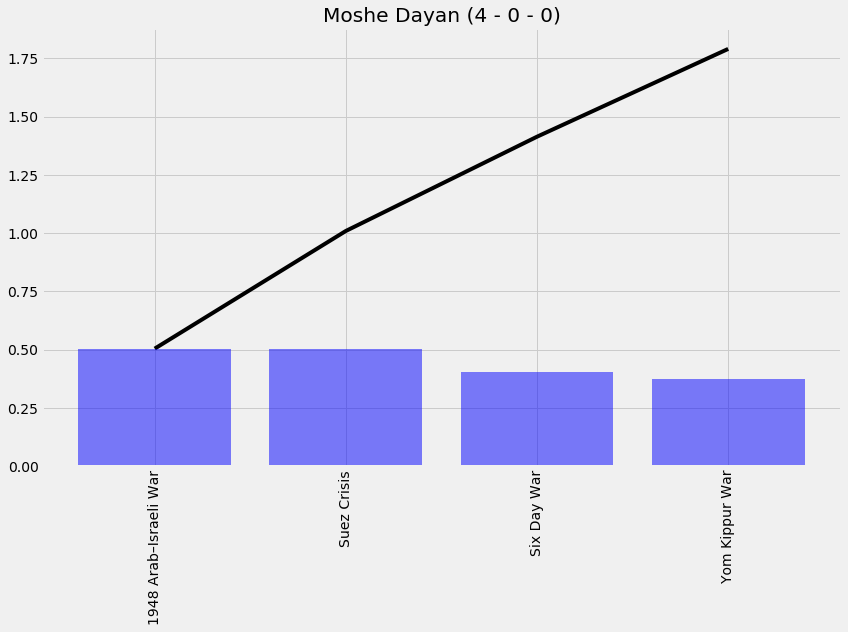

In [135]:
battle_list = []
graph('Moshe Dayan')

In [ ]:
df_battles

In [ ]:
df_model[df_model.Battle == 'Battle_of_Borodino'].transpose()

In [150]:
df_model[df_model.Battle == 'Six Day War']

,Battle,pos_x,VorD,Infantry_x,Cavalry_x,Artillery_x,Ships_x,Airforce_x,Special_x,pos_y,...,Artillery_y,Ships_y,Airforce_y,Special_y,infantry_diff,cavalry_diff,artillery_diff,ships_diff,airforce_diff,special_diff


In [ ]:
df_battles

In [ ]:
df_war = pd.DataFrame(war_list).sort_values('WAR', ascending = False).reset_index(drop = True)

In [ ]:
df_war.head()

In [ ]:
df_totalwar = df_totalwar = df_totalwar[df_totalwar.General != 'Capital punishment']
df_totalwar = df_totalwar[df_totalwar.General != 'Lieutenant general']

In [ ]:
df_totalwar[df_totalwar.General == 'Erwin Rommel']

In [136]:
import seaborn as sns

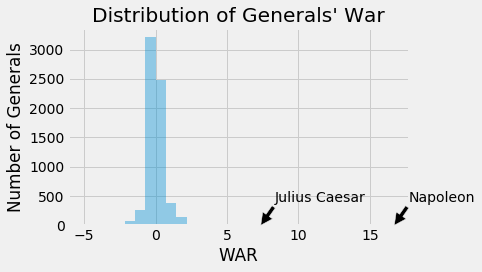

In [137]:
sns.distplot(df_totalwar['WAR'], kde = False, bins = 30)
plt.title("Distribution of Generals' War")
plt.ylabel('Number of Generals')
plt.annotate('Napoleon', xy = (16.713, 1), xytext = (17.713, 400), arrowprops = dict(facecolor = 'black'))
plt.annotate('Julius Caesar', xy = (7.364545, 1), xytext = (8.364545, 400), arrowprops = dict(facecolor = 'black'))
plt.tight_layout()
plt.savefig('/home/ethanarsht/Downloads/distplot.png')

In [ ]:
output_file('/home/ethanarsht/Downloads/google_doc_scatter_hover.html')
source = ColumnDataSource(data = dict(battles = df_totalwar.Battles,
                                      war = df_totalwar.WAR,
                                      general = df_totalwar.General))

hover = HoverTool(tooltips = [('General', '@general'),
                              ('Battles', '@battles'),
                              ('WAR', '@war'),
                                  ])
p = figure(title = 'WAR vs Number of Battles',
           plot_height = 600, 
           plot_width = 800,
          
           tools = [hover, "tap", 'box_zoom'])
p.circle(x = 'war', y = 'battles', size = 10, source = source)
p.xaxis.axis_label = 'WAR'
p.yaxis.axis_label = 'Battles'

url = "http://en.wikipedia.org/wiki/@general"
taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)
save(p)

In [ ]:
df_battles

In [168]:
def bokeh(commander):
    global df_battles
    battle_list = []
    df_battles = pd.DataFrame()
    commander_war(commander)

    df_battles.Year = df_battles.Year.fillna(-5000)
    df_battles.Year = df_battles.Year.astype(float, errors = 'ignore')
    df_battles = df_battles.sort_values('Year')
    wl = pd.DataFrame(df_battles.Outcome.value_counts())
    
    if 'V' in wl.index:
        wins = wl.loc['V', 'Outcome']
    else:
        wins = 0
    if 'D' in wl.index:
        losses = wl.loc['D', 'Outcome']
    else:
        losses = 0
    if 'I' in wl.index:
        draws = wl.loc['I', 'Outcome']
    else:
        draws = 0
    df_battles = df_battles.reset_index(drop = True)
    for i, row in df_battles.iterrows():
        df_battles.ix[i, 'cumulative'] = sum(df_battles.Value[0:i+1])
    
    
    source = ColumnDataSource(data = dict(battle = df_battles.Battle,
                              general = df_battles.General,
                              outcome = df_battles.Outcome,
                              value = df_battles.Value,
                              year = df_battles.Year,
                              cumulative = df_battles.cumulative))
    if all(x != -5000 for x in df_battles.Year):
        hover = HoverTool(tooltips = [('Battle', '@battle'),
                                  ('Outcome', '@outcome'),
                                  ('WAR', '@value'),
                                  ('Cumulative WAR', '@cumulative'),
                                  ('Year', '@year')])
    else:
        hover = HoverTool(tooltips = [('Battle', '@battle'),
                                  ('Outcome', '@outcome'),
                                  ('WAR', '@value'),
                                  ('Cumulative WAR', '@cumulative')
                                  ])
    
    x = list(df_battles.Battle)
    y = list(df_battles.Value)
    y_cum = list(df_battles.cumulative)
    
    output_file('/home/ethanarsht/Downloads/{}_bokeh_warg.html'.format(commander))
    
    p = figure(title = commander + ' ({} - {} - {})'.format(wins, draws, losses), 
               plot_width=800, 
               plot_height=600, 
               x_range = x, 
               tools = [hover])
    
    p.line(x = 'battle', y = 'cumulative', source = source, line_width = 5)
    
    color_mapper = CategoricalColorMapper(factors=['V', 'D', 'I'], palette=['Blue', 'Red', 'Yellow'])
    p.vbar(x = 'battle', 
           top = 'value', 
           source = source, 
           width = 0.9, 
           color={'field': 'outcome', 'transform': color_mapper},
           alpha = 0.5)
    
    p.xaxis.major_label_orientation = math.pi/2
#     show(p)
    save(p)

In [140]:
mka = df_run.loc[8965, 'belligerent']

In [141]:
mka

'Mustafa Kemal Atatürk'

In [149]:
df_battles

,Battle,General,Outcome,Value,Year,cumulative
0,1948 Arab–Israeli War,Moshe Dayan,V,0.504716,1948.0,0.504716
1,Suez Crisis,Moshe Dayan,V,0.504716,1956.0,1.009432
2,Six Day War,Moshe Dayan,V,0.404261,1967.0,1.413693
3,Yom Kippur War,Moshe Dayan,V,0.376520,1973.0,1.790213


In [174]:
battle_list = []
bokeh(u'Ariel Sharon')

2.1708169318


/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [ ]:
df_warchart = pd.DataFrame({'Labels': ['Win = 1', 'Replacement-Level Performance = .51', 'WAR From Battle = .49'],
              'Values': [1, .51, .49]})

In [ ]:
df_warchart = df_warchart.sort_values('Values', ascending = True)

In [ ]:
df_warchart

In [ ]:
df_warchart = df_warchart.iloc[::-1]

In [ ]:
fig = plt.figure(figsize = (12,9))
plt.style.use('fivethirtyeight')
plt.bar(df_warchart.index, df_warchart.Values, width = 1, color = ['red', 'blue', 'yellow'])
plt.xticks(df_warchart.index + .5, df_warchart.Labels, rotation = 45)
plt.xticks()
plt.title("Bonaparte's WAR in Battle of Borodino")
plt.tight_layout()
plt.savefig('napoleon_war_sample')

# ax.set_axis_bgcolor('gray')

In [190]:
df_warchart_two = pd.DataFrame({'Labels': ['Win = -1', 'Replacement-Level Performance = .49', 'WAR From Battle = -.51'],
              'Values': [-1, -.49, -.51]})

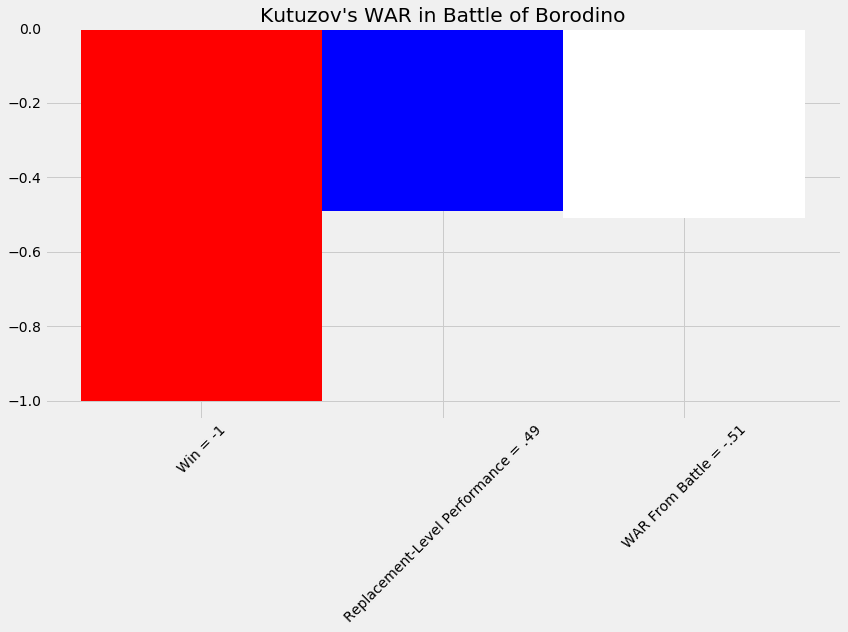

In [195]:
fig = plt.figure(figsize = (12,9))
plt.style.use('fivethirtyeight')
plt.bar(df_warchart_two.index, df_warchart_two.Values, width = 1, color = ['red', 'blue', 'white'])
plt.xticks(df_warchart_two.index, df_warchart_two.Labels, rotation = 45)
plt.title("Kutuzov's WAR in Battle of Borodino")
plt.tight_layout()
plt.savefig('/home/ethanarsht/Downloads/kutuzov_war_sample')

# ax.set_axis_bgcolor('gray')

In [ ]:
data = 

In [ ]:
probas = pd.DataFrame(lr.predict_proba(df_x))[1]

In [ ]:
df_y